# Music Genre Recognition Final Project
### Neural Networks and Deep Learning Couse
### Nico Ortiz de Zárate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/fma

/content/drive/MyDrive/fma


In [ ]:
!pip install audiomentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 8.3 MB/s eta 0:00:00


In [ ]:
# Imports
import torch
import torchvision
import torchaudio
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.optim import Adam
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
from sklearn.metrics import confusion_matrix
from torch.nn import functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
import random
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
import utils
import os

In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

## Dataset

The dataset we are using is the Free Music Archive (FMA) dataset containing over 100,000 tracks and 161 genres. In this project we will be using the small versiona, containing 8000 tracks and 52 genres.

In [ ]:
def setSeed(seed, gpuAvailable):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if gpuAvailable:
      print("CUDA is available")
      torch.cuda.manual_seed_all(seed)
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False

# Set a seed for reprodubcible testing
setSeed(1, torch.cuda.is_available())

CUDA is available


In [ ]:
# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('fma_small')

# Load metadata and features.
tracks = utils.load('fma_metadata/tracks.csv')
genres = utils.load('fma_metadata/genres.csv')
features = utils.load('fma_metadata/features.csv')
echonest = utils.load('fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [ ]:
def retrieveAudio(audioDir, trackID):
    # Given an audio directory and track ID, returns the path for mp3 file
    tid_str = '{:06d}'.format(trackID)
    return os.path.join(audioDir, tid_str[:3], tid_str + '.mp3')

File: fma_small/000/000002.mp3
Duration: 29.98s, 1321967 samples
(128, 512)


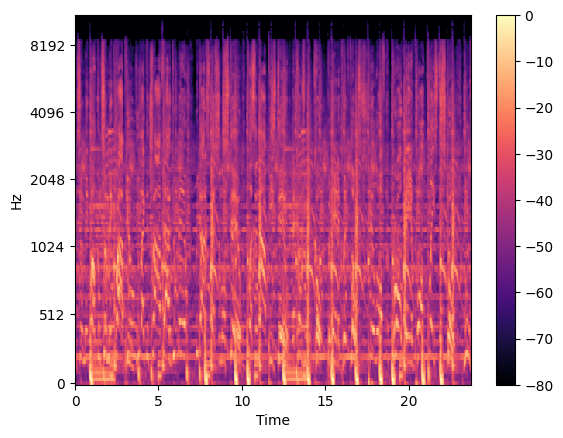

In [ ]:
'''
Processing code supplied by fma Github Repo
'''

AUDIO_DIR = 'fma_small'
filename = retrieveAudio(AUDIO_DIR, 2) # Retrieve a file
print('File: {}'.format(filename))
audio, sampleRate = librosa.load(filename, sr=None, mono=True) # Convert to audio signal
#audio, sampleRate = torchaudio.load(filename, format='mp3')
print('Duration: {:.2f}s, {} samples'.format(audio.shape[-1] / sampleRate, audio.size))

# We can also compute the spectrograph representation of the audio signal, which we will
# use for the 2D CNN case.
mel = librosa.feature.melspectrogram(y=audio, sr=sampleRate, n_fft=4096, hop_length=1024, n_mels=128)[:,:512] # Convert to Mel scale
log_mel = librosa.power_to_db(mel, ref=np.max)
print(log_mel.shape)

# Show example Mel Spectogram representation
plt.figure()
librosa.display.specshow(log_mel, hop_length=1024, x_axis='time', y_axis='mel')
plt.colorbar()

## 1D CNN Baseline

First, we implement as a baseline the 1D CNN from the reference paper of this project "Improved Music Genre Classification with Convolutional Neural Networks". The CNN takes as input the audio signal.

In [ ]:
# Create a subset because we are using small size dataset
subset = tracks.index[tracks['set', 'subset'] <= 'small']

assert subset.isin(tracks.index).all()
assert subset.isin(features.index).all()

features_all = features.join(echonest, how='inner').sort_index(axis=1)
print('Not enough Echonest features: {}'.format(features_all.shape))

tracks = tracks.loc[subset]
features_all = features.loc[subset]

tracks.shape, features_all.shape

Not enough Echonest features: (13129, 767)


((8000, 52), (8000, 518))

### Some of the tracks are corrputed, following code was used to remove them

In [ ]:
'''
for trackID in tracks.index:
  # For every track in subset, check if in directory and remove from subset if it is not
  tid_str = '{:06d}'.format(trackID)
  prefix = str(tid_str)[:3]
  file = f'fma_medium/{prefix}/{tid_str}'
  if(os.path.isfile(file) == False):
    print('ok', file)
  else:
    print('Dropping', trackID)
    tracks = tracks.drop(index=trackID)

print(len(tracks))'''

"\nfor trackID in tracks.index:\n  # For every track in subset, check if in directory and remove from subset if it is not\n  tid_str = '{:06d}'.format(trackID)\n  prefix = str(tid_str)[:3]\n  file = f'fma_medium/{prefix}/{tid_str}'\n  if(os.path.isfile(file) == False):\n    print('ok', file)\n  else:\n    print('Dropping', trackID)\n    tracks = tracks.drop(index=trackID)\n\nprint(len(tracks))"

In [ ]:
# COURRUPTED FILES
corruptedFiles = [52120, 52579, 99134, 108925, 133297, 98569, 98567, 98565]

# Remove corrupted files
for trackID in corruptedFiles:
  print('Dropping', trackID)
  tracks = tracks.drop(index = trackID)

'''
for trackID in tracks.index:
  tid_str = '{:06d}'.format(trackID)
  prefix = str(tid_str)[:3]
  file = f'fma_small/{prefix}/{tid_str}.mp3'
  if(os.path.isfile(file) == False):
    print('Dropping', trackID)
    tracks = tracks.drop(index=trackID)
'''

print(len(tracks))

Dropping 52120
Dropping 52579
Dropping 99134
Dropping 108925
Dropping 133297
Dropping 98569
Dropping 98567
Dropping 98565
7992


In [ ]:
# Split into train, val, and test sets
train = tracks[tracks['set', 'split'] == 'training']
val = tracks[tracks['set', 'split'] == 'validation']
test = tracks[tracks['set', 'split'] == 'test']
overfit = tracks.head(5)

print(train.shape, val.shape, test.shape, overfit.shape)

(6392, 52) (800, 52) (800, 52) (5, 52)


### Normalization
If we are running for the first time, we need to calculate both mean and std of the training data to then apply to the train, validation, and test data.



In [ ]:
normalize1D = False

def retrieveTrackMean1D(trackID):
  # Given a trackID, load the audio and return its mean
  path = retrieveAudio(AUDIO_DIR, trackID)
  signal, sampleRate = librosa.load(path, sr=None, mono=True)
  return np.mean(signal)

def retrieveTrackStd1D(trackID):
  # Given a track ID, load the audio and return its variance
  path = retrieveAudio(AUDIO_DIR, trackID)
  signal, sampleRate = librosa.load(path, sr=None, mono=True)
  return np.std(signal)

def trainDataStatistics1D(trainset):
  # Return mean and standard deviation of the given train set
  mean = list()
  std = list()

  for trackID in trainset.index:
    mean.append(retrieveTrackMean1D(trackID))
    std.append(retrieveTrackStd1D(trackID))

  trainMean, trainStd = np.array(mean), np.array(std)
  return np.mean(trainMean), np.mean(trainStd)

if normalize1D == True:
  trainMean1D, trainStd1D = trainDataStatistics1D(train)
  np.save('trainMean', trainMean1D)
  np.save('trainStd', trainStd1D)
  print(trainMean1D, trainStd1D)


In [ ]:
normalize2D = False

def retrieveSpectMean2D(trackID):
  # Given a trackID, return mel spectogram's mean
  path = retrieveAudio(AUDIO_DIR, trackID)
  signal, sampleRate = librosa.load(path, sr=None, mono=True)
  mel = librosa.feature.melspectrogram(y=signal, sr=sampleRate, n_fft=4096, hop_length=1024, n_mels=128)[:,:512] # Convert to Mel scale
  log_mel = librosa.power_to_db(mel, ref=np.max)
  melMean = np.mean(log_mel, axis=1)
  return melMean

def retrieveSpectStd2D(trackID):
  # Given a track ID, return mel spectrogram's variance
  path = retrieveAudio(AUDIO_DIR, trackID)
  signal, sampleRate = librosa.load(path, sr=None, mono=True)
  mel = librosa.feature.melspectrogram(y=signal, sr=sampleRate, n_fft=4096, hop_length=1024, n_mels=128)[:,:512] # Convert to Mel scale
  log_mel = librosa.power_to_db(mel, ref=np.max)
  melStd = np.std(log_mel, axis=1)
  return melStd

def trainDataStatistics2D(trainset):
  # Return the mean and standard deviation of the given train set
  mean = list()
  std = list()

  for trackID in trainset.index:
    mean.append(retrieveSpectMean2D(trackID))
    std.append(retrieveSpectStd2D(trackID))

  trainMean, trainStd = np.array(mean), np.array(std)
  return np.mean(trainMean, axis=0), np.mean(trainStd, axis=0)

if normalize2D == True:
  trainMean2D, trainStd2D = trainDataStatistics2D(train)
  np.save('trainMelSpectMean', trainMean2D)
  np.save('trainMelSpectStd', trainStd2D)
  print(trainMean2D, trainStd2D)

Dataloader

In [ ]:
# Create a data loader for the dataset
class FMADataset(Dataset):
    def __init__(self, audioDir, splitLabel, subset, convDims):
        '''
        audioDir: fma_small
        splitLabel: Either train, val, or test, used for determining whether
                    to apply dat augmentation
        subset: Either train, val, or test set
        convDims: Either 1, 2, 3 where 1 referes to 1D case, 2 refers to 2D case
                  and 3 refers to the combined case
        '''
        self.labelFile = utils.load('fma_metadata/tracks.csv')
        self.genreFile = utils.load('fma_metadata/genres.csv')
        self.audioDir = audioDir
        self.splitLabel = splitLabel
        self.subset = subset
        self.convDims = convDims
        self.numSamples = 660000 # Approximately half of the original 30 seconds
        self.trainMean = np.load('trainMean.npy')
        self.trainStd = np.load('trainStd.npy')
        self.spectMean = np.load('trainMelSpectMean.npy')
        self.spectStd = np.load('trainMelSpectStd.npy')

        # Build dictionary with the top 8 genres, which will be our labels
        topGenres = list(LabelEncoder().fit(self.subset['track', 'genre_top']).classes_)
        self.genreDic = dict()
        for genreLabel, label in zip(topGenres, range(8)):
            self.genreDic[genreLabel] = label

    def __len__(self):
        # Returns length of dataset
        return len(self.subset)

    def __getitem__(self, index):
        # Given an index, first find the trackID associated with track, and then
        # return the audio signal and label for that track

        trackID = self.subset.index[index]
        audioSamplePath = self.getAudioSamplePath(self.audioDir, trackID)
        label = self.getAudioLabel(trackID, self.labelFile)

        signal, sampleRate = librosa.load(audioSamplePath, sr=None, mono=True) # Load
        signal = self.audioPipeline(signal, sampleRate) # Pre-process

        return signal, label


    def normalizeAudio(self, signal, sampleRate):
        # Return z-score normalization of audio signal
        norm = (signal-self.trainMean) / (self.trainStd)
        return norm

    def normalizeSpectrogram(self, logMel):
        # Return z-score normalization of spectrogram
        norm = (logMel - self.spectMean[:,None]) / (self.spectStd[:,None])
        return norm

    def dataAugmentation(self, signal, sampleRate):
        # Given the training set, add some guassian noise and time stretching
        augment = Compose([
                          AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
                          TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5)
        ])
        return augment(signal, sampleRate)

    def audioPipeline(self, signal, sampleRate):
        # This function takes an audio signal and does a number of processing steps
        # including resampling, mixing down to a mono, and cutting.

        # Only use the first half of the signal, just so my computer can survive this <3
        signal = signal[:self.numSamples]

        # Data augmentation
        if(self.splitLabel == 'train'):
          signal = self.dataAugmentation(signal, sampleRate)

        #If we are in 2D case, take Mel spectrograms
        if(self.convDims == 2 or self.convDims == 3):

            mel = librosa.feature.melspectrogram(y=signal, sr=sampleRate, n_fft=4096, hop_length=1024, n_mels=128)[:,:512] # Convert to Mel scale
            log_mel = librosa.power_to_db(mel, ref=np.max)
            log_mel = log_mel.reshape((1, 128, 512))
            log_mel = self.normalizeSpectrogram(log_mel)

            log_mel = torch.from_numpy(log_mel)

        # In 1D case, just reshape and return
        if(self.convDims == 1 or self.convDims == 3):
            # Normalize
            signal = self.normalizeAudio(signal, sampleRate)

            signal1D = torch.from_numpy(signal.reshape((1, len(signal))))

        # Return based on model we are using
        if(self.convDims == 3):
            return (signal1D, log_mel)
        elif(self.convDims == 2):
          return log_mel
        elif(self.convDims == 1):
          return signal1D


    def getAudioSamplePath(self, audioDir, trackID):
        # given an audio directory and a track ID, returns the path to
        # the audio file

        tid_str = '{:06d}'.format(trackID)
        path = os.path.join(self.audioDir, tid_str[:3], tid_str + '.mp3')
        return path

    def getAudioLabel(self, trackID, subset):
        # Given a track ID and the subset, returns the genre label (string)
        # associated to the audio signal.

        genreLabel = self.subset.track.genre_top.loc[trackID]
        label = self.genreDic[genreLabel]
        return label

In [ ]:
# Split data for the 1D CNN Model
trainData = FMADataset('fma_small', 'train', train,1)
testData = FMADataset('fma_small', 'test', test, 1)
valData = FMADataset('fma_small', 'val', val, 1)
overfitData = FMADataset('fma_small', 'small', overfit, 1)

signal, label = trainData[0]


In [ ]:
# Let's play a piece of audio for sanity check
signal, label = trainData[10]
ipd.Audio(signal, rate=44100)

In [ ]:
# Load all the different partitions of the data for 1D CNN
trainDataLoader = DataLoader(trainData, batch_size=16, shuffle=True, num_workers=2, drop_last=True)
testDataLoader = DataLoader(testData, batch_size=16, shuffle=True, num_workers=2, drop_last=True)
validationDataLoader = DataLoader(valData, batch_size=16, shuffle=True, num_workers=2, drop_last=True)
overfitDataLoader = DataLoader(overfitData, batch_size=1)

In [ ]:
# Display signal and label, play audio for final sanity check.
train_features, train_labels = next(iter(trainDataLoader))
print(f"Feature batch shape: {train_features.size()}")
print(train_labels)
print(f"Labels batch shape: {len(train_labels)}")
signal = train_features[0].squeeze()
label = train_labels[0]
print(f"Label: {label}")
testAudio = train_features[0]
ipd.Audio(testAudio, rate=44100)

Feature batch shape: torch.Size([16, 1, 660000])
tensor([7, 6, 0, 1, 5, 3, 1, 2, 3, 4, 4, 4, 0, 0, 2, 1])
Labels batch shape: 16
Label: 7


In [ ]:
from torch.nn import Module, Linear, Sequential, Conv1d, ReLU, BatchNorm1d, MaxPool1d, AvgPool1d, Flatten, Softmax, Dropout
# Build 1D CNN Model

class convolutionalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.block = Sequential(
            Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            BatchNorm1d(out_channels),
            ReLU()
        )

    def forward(self, x):
        return self.block(x)

class rawAudioModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.mainConvBlock = Sequential(
        convolutionalBlock(in_channels=1, out_channels=32, kernel_size=11, stride=3, padding=4),
        convolutionalBlock(in_channels=32, out_channels=32, kernel_size=11, stride=3, padding=2),
        nn.MaxPool1d(kernel_size=16, stride=2),
        #Dropout(0.2),
        convolutionalBlock(in_channels=32, out_channels=64, kernel_size=9, stride=2, padding=2),
        convolutionalBlock(in_channels=64, out_channels=64, kernel_size=9, stride=2, padding=2),
        MaxPool1d(kernel_size=16, stride=2),
        #Dropout(0.2),
        convolutionalBlock(in_channels=64, out_channels=128, kernel_size=7, stride=2, padding=2),
        convolutionalBlock(in_channels=128, out_channels=128, kernel_size=7, stride=2, padding=2),
        MaxPool1d(kernel_size=16, stride=16),
        #Dropout(0.2),
        convolutionalBlock(in_channels=128, out_channels=256, kernel_size=5, stride=2, padding=2),
        convolutionalBlock(in_channels=256, out_channels=256, kernel_size=5, stride=2, padding=2),
        MaxPool1d(kernel_size=16, stride=2)
    )

        self.flatten = Flatten()

        self.fullyConnectedLayer = Sequential(
            Linear(512,256),
            ReLU(),
            Dropout(0.2),

            Linear(256,64),
            ReLU(),
            Dropout(0.2),

            Linear(64,8)
            # NO SOFTMAX because it's included in CrossEntropyLoss for pytorch
        )

    def forward(self, x):
        y =  self.mainConvBlock(x)

        y = self.flatten(y)

        out = self.fullyConnectedLayer(y)

        return out


    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()


In [ ]:
def confusionMatrixElements(y_logits, truth):
    # Given the prediction values and true values, calculate the confusion matrix
    # consisting of TP, TN, FP, FN

    # Convert to one hot encoding to use sklearn confusion matrix
    y_prob = F.softmax(y_logits, dim=1)
    y_pred = y_prob.argmax(dim=1)
    y_predOneHot = F.one_hot(y_pred, num_classes=8).cpu().numpy()[0]
    truthOneHot = F.one_hot(truth, num_classes=8).cpu().numpy()[0]

    confusionMatrix = confusion_matrix(truthOneHot, y_predOneHot)

    TP = np.diag(confusionMatrix) # True positive
    FN = np.sum(confusionMatrix, axis=1) - TP # False negative
    FP = np.sum(confusionMatrix, axis=0) - TP # False positive
    TN = np.sum(confusionMatrix) - (TP + FN + FP) # True negative

    return TP, FP, TN, FN, confusionMatrix


In [ ]:
def calculateEpochMetrics(loss, TP, FP, TN, FN, CM):
    # Given loss, TP, FP, TN, FN return metrics: accuracy, precision, recall, F1 score

    accuracy = (TP + TN)/(TP + FP + TN + FN)
    avgAccuracy = np.sum(accuracy)/2 # Have to divide to get macro average accuracy

    precision = TP/(TP + FP)
    avgPrecision = np.sum(precision)/2

    recall = TP/(TP + FN)
    avgRecall = np.sum(recall)/2

    avgF1Score = 2*(avgPrecision * avgRecall)/(avgPrecision + avgRecall)

    metricsDictionary = {
        'loss' : loss.detach().cpu().numpy(),
        'accuracy' : avgAccuracy,
        'precision' : avgPrecision,
        'recall' : avgRecall,
        'F1Score' : avgF1Score,
        'confusionMatrix' : CM
    }

    return metricsDictionary


In [ ]:
def plotTrainingResults(epochs, trainingMetrics, evalMetrics):
    # Given the training/validation loss and the accuracy, plot the results
    fig1, axes1 = plt.subplots(1, 2, figsize=(12, 8))

    # Plot loss over epochs
    trainLoss = dictToArray(trainingMetrics, 'loss')
    valLoss = dictToArray(evalMetrics, 'loss')
    axes1[0].plot(range(1, epochs+1), trainLoss, label='Training loss', color='blue')
    axes1[0].plot(range(1, epochs+1), valLoss, label='Validation loss', color='orange')
    axes1[0].set_title(f'Loss over {epochs} epochs')
    axes1[0].set_xlabel('Epochs')
    axes1[0].set_ylabel('Training Loss')
    axes1[0].legend()

    # Plot accuracy over epochs
    trainAcc = dictToArray(trainingMetrics, 'accuracy')
    valAcc = dictToArray(evalMetrics, 'accuracy')
    axes1[1].plot(range(1, epochs+1), trainAcc, label='Training Accuracy', color='blue')
    axes1[1].plot(range(1, epochs+1), valAcc, label='Validation Accuracy', color='orange')
    axes1[1].set_title(f'Accuracy over {epochs} epochs')
    axes1[1].set_xlabel('Epochs')
    axes1[1].set_ylabel('Accuracy')
    axes1[1].legend()

    fig2, axes2 = plt.subplots(1, 3, figsize=(12, 4))

    # Plot precision over epochs
    trainPrecision = dictToArray(trainingMetrics, 'precision')
    valPrecision = dictToArray(evalMetrics, 'precision')
    axes2[0].plot(range(1, epochs+1), trainPrecision, label='Training Precision', color='blue')
    axes2[0].plot(range(1, epochs+1), valPrecision, label='Validation Precision', color='orange')
    axes2[0].set_title(f'Precision over {epochs} epochs')
    axes2[0].set_xlabel('Epochs')
    axes2[0].set_ylabel('Precision')
    axes2[0].legend()

    # Plot recall over epochs
    trainRecall = dictToArray(trainingMetrics, 'recall')
    valRecall = dictToArray(evalMetrics, 'recall')
    axes2[1].plot(range(1, epochs+1), trainRecall, label='Training Recall', color='blue')
    axes2[1].plot(range(1, epochs+1), valRecall, label='Validation Recall', color='orange')
    axes2[1].set_title(f'Recall over {epochs} epochs')
    axes2[1].set_xlabel('Epochs')
    axes2[1].set_ylabel('Recall')
    axes2[1].legend()

    # Plot F1 score over epochs
    trainF1 = dictToArray(trainingMetrics, 'F1Score')
    valF1 = dictToArray(evalMetrics, 'F1Score')
    axes2[2].plot(range(1, epochs+1), trainF1, label='Training F1 Score', color='blue')
    axes2[2].plot(range(1, epochs+1), valF1, label='Validation F1 Score', color='orange')
    axes2[2].set_title(f'F1 Score over {epochs} epochs')
    axes2[2].set_xlabel('Epochs')
    axes2[2].set_ylabel('F1 Score')
    axes2[2].legend()

In [ ]:
def trainEpoch(model, loss_fn, opt, dataLoader):
  # Given a model, data iterator, loss function, train one epoch of the model
    epochTrainLoss = 0
    epoch_trainTP = 0
    epoch_trainFP = 0
    epoch_trainTN = 0
    epoch_trainFN = 0
    epoch_CM = 0
    model.train()

    iterator = tqdm(dataLoader, desc='Training')
    for batch_x, batch_y in iterator:
        # zero out gradients
        opt.zero_grad()

        if(len(batch_x) == 2):
            batch_x[0] = batch_x[0].to(device)
            batch_x[1] = batch_x[1].to(device)
            y_pred = model(batch_x[0], batch_x[1]) # logits
        else:
            batch_x = batch_x.to(device) # signal input
            y_pred = model(batch_x) # logits

        batch_y = batch_y.to(device) # associated label

        # Compute loss and batch metrics

        loss = loss_fn(y_pred, batch_y)
        TP, FP, TN, FN, CM = confusionMatrixElements(y_pred, batch_y)

        # Backpropagate
        loss.backward()
        currentLoss = loss.detach().cpu().numpy()
        iterator.set_description(f"Train loss: {currentLoss}")

        # Update weights
        opt.step()

        # Update epch metrics
        epochTrainLoss += loss/len(trainDataLoader)
        epoch_trainTP += TP
        epoch_trainFP += FP
        epoch_trainTN += TN
        epoch_trainFN += FN
        epoch_CM += CM

    print('Epoch train loss:', epochTrainLoss)

    epochMetrics = calculateEpochMetrics(epochTrainLoss, epoch_trainTP, epoch_trainFP, epoch_trainTN, epoch_trainFN, epoch_CM)

    return epochMetrics


In [ ]:
def evaluateEpoch(model, loss_fn, dataLoader):

    model.eval()
    epochValLoss = 0
    epoch_valTP = 0
    epoch_valFP = 0
    epoch_valTN = 0
    epoch_valFN = 0
    epoch_CM = 0
    with torch.no_grad():

        iterator = tqdm(dataLoader, desc='Validation')
        for batch_x, batch_y in iterator:

            if(len(batch_x) == 2):
                batch_x[0] = batch_x[0].to(device)
                batch_x[1] = batch_x[1].to(device)
                y_pred = model(batch_x[0], batch_x[1]) # logits
            else:
                batch_x = batch_x.to(device) # signal input
                y_pred = model(batch_x) # logits

            # Compute loss and metrics
            batch_y = batch_y.to(device) # associated label

            #print('device', device)
            loss = loss_fn(y_pred, batch_y)
            TP, FP, TN, FN, CM = confusionMatrixElements(y_pred, batch_y)

            currentLoss = loss.detach().cpu().numpy()
            iterator.set_description(f"Validation loss: {currentLoss}")

            epochValLoss += loss/len(validationDataLoader)
            epoch_valTP += TP
            epoch_valFP += FP
            epoch_valTN += TN
            epoch_valFN += FN
            epoch_CM += CM

        print('Epoch validation loss', epochValLoss)

        epochMetrics = calculateEpochMetrics(epochValLoss, epoch_valTP, epoch_valFP, epoch_valTN, epoch_valFN, epoch_CM)

    return epochMetrics


In [ ]:
from torch.nn import CrossEntropyLoss

def trainModel(model, loss_fn, device, optimizer, epochs, trainDataLoader, validationDataLoader):
    # Function that trains a given model

    # Model and loss function
    model = model.to(device)
    loss_fn = CrossEntropyLoss()
    loss_fn = loss_fn.to(device)

    # Training and Eval metrics over epochs
    trainingMetrics = list()
    evalMetrics = list()

    for epoch in range(epochs):
        print(f'Epoch {epoch}')
        # Plot as we go to control
        if epoch > 1:
          plotTrainingResults(epoch, trainingMetrics, evalMetrics)

        # Iterate over each epoch and train/validate
        epochTrainMetrics = trainEpoch(model, loss_fn, optimizer, trainDataLoader)
        trainingMetrics.append(epochTrainMetrics)

        epochValMetrics = evaluateEpoch(model, loss_fn, validationDataLoader)
        evalMetrics.append(epochValMetrics)

        # Save as we go in the case internet disconnects again </3

        torch.save(epochTrainMetrics, f'{epoch}Run_trainingMetrics_2D_running')
        torch.save(epochValMetrics, f'{epoch}Run_validationMetrics_2D_running')
        torch.save(model.state_dict(), f'TwoDModel_running_{epoch}s')

    return trainingMetrics, evalMetrics


In [ ]:
TRAIN = False
SAVE_RUN = False
SAVE_MODEL = False

model = rawAudioModel()
loss_fn = CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
epochs = 25

if TRAIN: trainingMetrics, evalMetrics = trainModel(model, loss_fn, device, optimizer, epochs, trainDataLoader, validationDataLoader) # Both are sorted in order of epochs already

if SAVE_RUN:
    torch.save(trainingMetrics, f'{epochs}Run_trainingMetrics_1D')
    torch.save(evalMetrics, f'{epochs}Run_validationMetrics_1D')

if SAVE_MODEL:
    torch.save(model.state_dict(), 'oneDModel')

In [ ]:
def dictToArray(metrics, element):
    # Takes a dictionary (metrics) and returns the respective metric needed (element) in list form for plotting purposes
    metricList = list()
    for i in range(len(metrics)):
        #print(metrics[i][element])
        metricList.append(metrics[i][element])

    return metricList

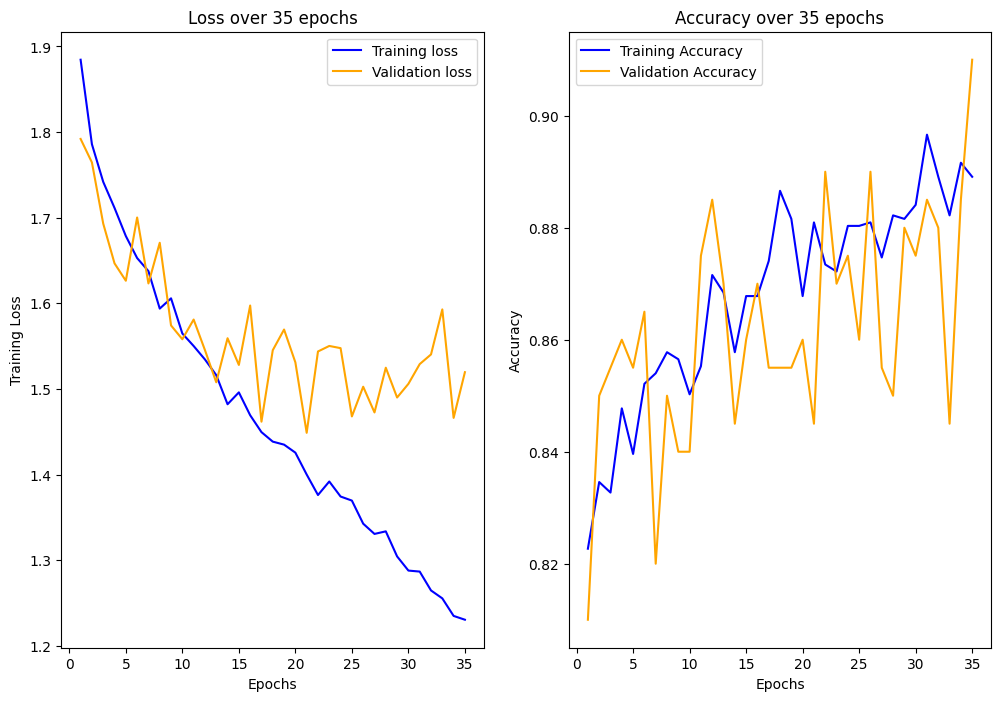

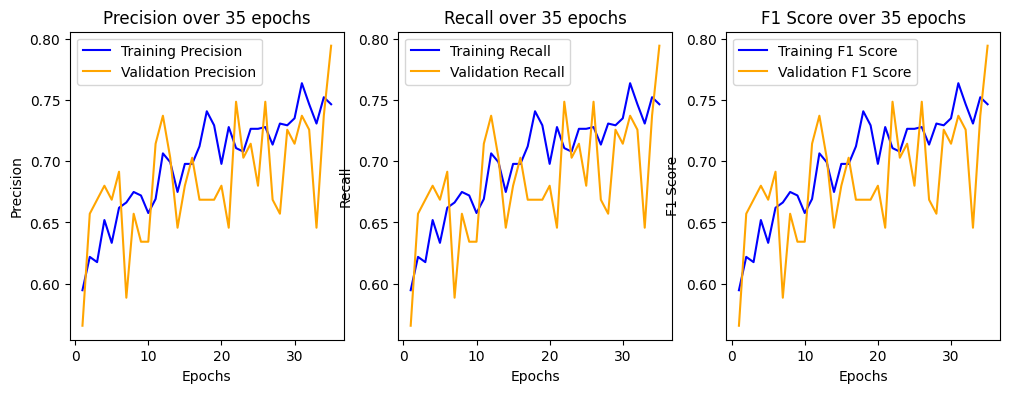

In [ ]:
testTrainingMetrics, testEvalMetrics = torch.load('25Run_trainingMetrics_1D'), torch.load('25Run_validationMetrics_1D')
plotTrainingResults(epochs, testTrainingMetrics, testEvalMetrics)

In [ ]:
def testModel(model, loss_fn, device, testDataLoader):
    # After training, test model on respective test set

    model.eval()
    testLoss = 0
    testTP = 0
    testFP = 0
    testTN = 0
    testFN = 0
    confusionMatrix = 0
    loss_fn = loss_fn.to(device)
    with torch.no_grad():

        iterator = tqdm(testDataLoader, desc='Test')
        for batch_x, batch_y in iterator:

            if(len(batch_x) == 2):
                print(type(batch_x[0]), type(batch_x[1]))
                batch_x[0] = batch_x[0].to(device)
                batch_x[1] = batch_x[1].to(device)
                y_pred = model(batch_x[0], batch_x[1]) # logits
            else:
                batch_x = batch_x.to(device) # signal input
                y_pred = model(batch_x) # logits

            batch_y = batch_y.to(device)

            # Compute loss and metrics
            loss = loss_fn(y_pred, batch_y)
            TP, FP, TN, FN, CM = confusionMatrixElements(y_pred, batch_y)

            currentLoss = loss.detach().cpu().numpy()
            iterator.set_description(f"Test loss: {currentLoss}")

            testLoss += loss/len(testDataLoader)
            testTP += TP
            testFP += FP
            testTN += TN
            testFN += FN
            confusionMatrix += CM

        testMetrics = calculateEpochMetrics(testLoss, testTP, testFP, testTN, testFN, confusionMatrix)

    return testMetrics

#testMetrics = testModel(model, loss_fn)
#print(testMetrics)

#if SAVE_RUN:
#      torch.save(testMetrics, f'{epochs}Run_testMetrics_1D')

## 2D CNN Baseline

Next, we implement the baseline for the 2D CNN case, where now we have as input the spectrogram representation of the signals.\

In [ ]:
# Split data
trainData2D = FMADataset('fma_small', 'small', train, 2)
testData2D = FMADataset('fma_small', 'small', test, 2)
valData2D = FMADataset('fma_small', 'small', val, 2)
overfit2D = FMADataset('fma_small', 'small', overfit, 2)

signal, label = trainData2D[0]
print('signal shape', signal.shape)

# Load data
trainDataLoader2D = DataLoader(trainData2D, batch_size=16, shuffle=True, num_workers=4)
testDataLoader2D = DataLoader(testData2D, batch_size=16, shuffle=True, num_workers=4)
validationDataLoader2D = DataLoader(valData2D, batch_size=16, shuffle=True, num_workers=4)
overfitDataLoader2D = DataLoader(overfit2D, batch_size=16)

signal shape torch.Size([1, 128, 512])


In [ ]:
# Display signal and label for some sanity checking.
train_features2D, train_labels2D = next(iter(trainDataLoader2D))
print(f"Feature batch shape: {train_features2D.size()}")
print(train_labels2D)
print(f"Labels batch shape: {len(train_labels2D)}")
signal = train_features2D[0].squeeze()
label = train_labels2D[0]
print(f"Label: {label}")

Feature batch shape: torch.Size([16, 1, 128, 512])
tensor([2, 6, 4, 1, 0, 0, 6, 3, 4, 5, 2, 1, 7, 7, 1, 6])
Labels batch shape: 16
Label: 2


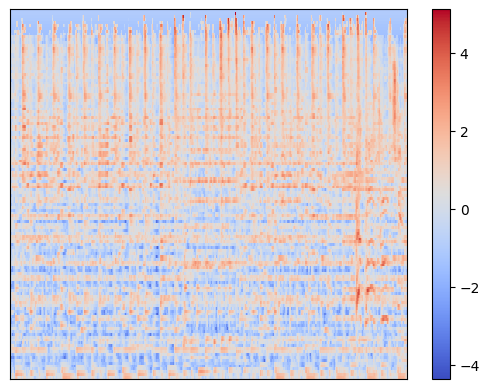

In [ ]:
# Plot Mel spectrogram after loading data
plt.figure()
librosa.display.specshow(signal.detach().numpy())
plt.colorbar()

In [ ]:
from torch.nn import Sequential, Conv2d, BatchNorm2d, MaxPool2d, AvgPool2d, Linear, ReLU, Flatten
# Build 2D CNN Model

class resBlock(nn.Module):
    def __init__(self):
      super().__init__()

      self.mainPath = Sequential(
          Conv2d(in_channels=1, out_channels=256, kernel_size=(4,512), padding=2),
          BatchNorm2d(256),
          MaxPool2d(1),
          ReLU(),
          #Dropout(0.5),
          Conv2d(in_channels=256, out_channels=256, kernel_size=(4,4), padding=1),
          BatchNorm2d(256),
          MaxPool2d(1),
          ReLU(),
          #Dropout(0.5),
          Conv2d(in_channels=256, out_channels=256, kernel_size=(4,4), padding=1),
          BatchNorm2d(256),
          ReLU(),
          Dropout(0.5)
      )

      self.shortcut = Sequential(
          Conv2d(in_channels=1, out_channels=256, kernel_size=(4,512), padding=1),
          BatchNorm2d(256),
          MaxPool2d(1)
      )

      self.relu = ReLU()

    def forward(self, x):
      out = self.relu(self.mainPath(x) + self.shortcut(x))
      return out

class TwoDModel(nn.Module):

    def __init__(self):
        """
        Input shape of Mel spectogram -> (128, 512)
        """
        super().__init__()

        self.resBlock = resBlock()

        self.maxPool = MaxPool2d(1, 32)

        self.avgPool = AvgPool2d(1, 32)

        self.flatten = Flatten()

        self.fullyConnectedLayers = Sequential(
            Linear(in_features=2048, out_features=512),
            Dropout(0.5),
            Linear(in_features=512, out_features=128),
            Dropout(0.5),
            Linear(in_features=128, out_features=64),
            Dropout(0.5),
            Linear(in_features=64, out_features=8)
        )

    def forward(self, x):
        y = self.resBlock(x.float())

        maxPool = self.maxPool(y)

        avgPool = self.avgPool(y)

        y = torch.cat([maxPool, avgPool], dim=1)

        y = self.flatten(y)

        out = self.fullyConnectedLayers(y)

        return out

In [ ]:
TRAIN = False
model = TwoDModel()
loss_fn = CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-4)
epochs = 15

if TRAIN: trainingMetrics2D, evalMetrics2D = trainModel(model, loss_fn, device, optimizer, epochs, trainDataLoader2D, validationDataLoader2D) # Both are sorted in order of epochs already

SAVE_RUN = False
SAVE_MODEL = False
if SAVE_RUN:
    torch.save(trainingMetrics2D, f'{epochs}Run_trainingMetrics_2D')
    torch.save(evalMetrics2D, f'{epochs}Run_validationMetrics_2D')

if SAVE_MODEL:
    torch.save(model.state_dict(), 'TwoDModel')

In [ ]:
print(dictToArray(trainingMetrics2D, 'accuracy'))
plotTrainingResults(epochs, trainingMetrics2D, evalMetrics2D)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-41-52af357083e9>", line 1, in <cell line: 1>
    print(dictToArray(trainingMetrics2D, 'accuracy'))
NameError: name 'trainingMetrics2D' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/p

In [ ]:
model.load_state_dict(torch.load('TwoDModel_running_15s'))
model.to(device)
test2DMetrics = testModel(model, loss_fn, device, testDataLoader2D)
print(test2DMetrics)

Test loss: 2.5223140716552734: 100%|██████████| 50/50 [02:17<00:00,  2.75s/it]

{'loss': array(2.0849855, dtype=float32), 'accuracy': 0.855, 'precision': 0.6685714285714286, 'recall': 0.6685714285714286, 'F1Score': 0.6685714285714286, 'confusionMatrix': array([[321,  29],
       [ 29,  21]])}


In [ ]:
def loadPartialResults(epochs):
    trainingMetrics2D, evalMetrics2D = [], []
    for i in range(1, epochs+1):
        trainingMetrics2D.append(torch.load(f'{i}Run_trainingMetrics_2D_running'))
        evalMetrics2D.append(torch.load(f'{i}Run_validationMetrics_2D_running'))

    torch.save(trainingMetrics2D, '15Run_trainingMetrics_2D')
    torch.save(evalMetrics2D, '15Run_validationMetrics_2D')

    return trainingMetrics2D, evalMetrics2D

trainingMetrics2D, evalMetrics2D = loadPartialResults(15)



```
# This is formatted as code
```

## Combined Architecture

Finally, we implement an architecture that combines both the 1D and 2D features.

In [ ]:
# Clear GPU
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Split data
trainDataCombined = FMADataset('fma_small', 'small', train, 3)
testDataCombined = FMADataset('fma_small', 'small', test, 3)
valDataCombined = FMADataset('fma_small', 'small', val, 3)
overfitCombined = FMADataset('fma_small', 'small', overfit, 3)

signal, label = trainDataCombined[0]

# Load split data
trainDataLoaderCombined = DataLoader(trainDataCombined, batch_size=16, shuffle=True, num_workers=4)
testDataLoaderCombined = DataLoader(testDataCombined, batch_size=16, shuffle=True, num_workers=4)
validationDataLoaderCombined = DataLoader(valDataCombined, batch_size=16, shuffle=True, num_workers=4)
overfitDataLoaderCombined = DataLoader(overfitCombined, batch_size=1)

<class 'tuple'>
(tensor([[0.0028, 0.0028, 0.0028,  ..., 0.9699, 1.4563, 1.5745]]), tensor([[[-4.3009, -2.3967, -1.9881,  ..., -1.5682, -1.3787, -1.1163],
         [-5.6407, -4.0682, -3.8486,  ..., -3.6072, -2.9980, -2.6275],
         [-5.3401, -4.3443, -4.1027,  ..., -3.9084, -3.6028, -3.3678],
         ...,
         [-1.0332, -1.0332, -1.0332,  ..., -1.0332, -1.0332, -1.0332],
         [-1.0189, -1.0189, -1.0189,  ..., -1.0189, -1.0189, -1.0189],
         [-1.0157, -1.0157, -1.0157,  ..., -1.0157, -1.0157, -1.0157]]])) 3
1d signal shape torch.Size([1, 660000])
2d signal shape torch.Size([1, 128, 512])


In [ ]:
from torch.nn import Module, Linear, Sequential, Conv1d, ReLU, Sigmoid, BatchNorm1d, MaxPool1d, Flatten, Softmax, Dropout, AvgPool1d
# Build combined CNN Model

class oneDPathBlock(nn.Module):

    def __init__(self):
        super().__init__()
        self.path1D = Sequential(
        convolutionalBlock(in_channels=1, out_channels=32, kernel_size=11, stride=5, padding=2),
        convolutionalBlock(in_channels=32, out_channels=32, kernel_size=11, stride=2, padding=2),
        nn.MaxPool1d(kernel_size=16, stride=2),
        #Dropout(0.2),
        convolutionalBlock(in_channels=32, out_channels=64, kernel_size=9, stride=2, padding=2),
        convolutionalBlock(in_channels=64, out_channels=64, kernel_size=9, stride=2, padding=2),
        MaxPool1d(kernel_size=16, stride=2),
        #Dropout(0.2),
        convolutionalBlock(in_channels=64, out_channels=128, kernel_size=7, stride=2, padding=2),
        convolutionalBlock(in_channels=128, out_channels=128, kernel_size=7, stride=2, padding=2),
        MaxPool1d(kernel_size=16, stride=16),
        #Dropout(0.2),
        convolutionalBlock(in_channels=128, out_channels=256, kernel_size=5, stride=2, padding=2),
        convolutionalBlock(in_channels=256, out_channels=256, kernel_size=5, stride=2, padding=2),
        MaxPool1d(kernel_size=16, stride=2)
    )

    def forward(self, x):
        out = self.path1D(x)
        return out

class resCombinedBlock(nn.Module):
    def __init__(self):
      super().__init__()

      self.mainPath = Sequential(
          Conv2d(in_channels=1, out_channels=256, kernel_size=(4,512), padding=2),
          BatchNorm2d(256),
          MaxPool2d(1),
          ReLU(),
          Dropout(0.5),
          Conv2d(in_channels=256, out_channels=256, kernel_size=(4,4), padding=1),
          BatchNorm2d(256),
          MaxPool2d(1),
          ReLU(),
          Dropout(0.5),
          Conv2d(in_channels=256, out_channels=256, kernel_size=(4,4), padding=1),
          BatchNorm2d(256)
      )

      self.shortcut = Sequential(
          Conv2d(in_channels=1, out_channels=256, kernel_size=(4,512), padding=1),
          BatchNorm2d(256),
          MaxPool2d(1)
      )

      self.relu = ReLU()

    def forward(self, x):
      out = self.relu(self.mainPath(x) + self.shortcut(x))
      return out


class twoDPathBlock(nn.Module):

    def __init__(self):
        super().__init__()
        self.path2D = resCombinedBlock()


    def forward(self, x):
        out = self.path2D(x)
        return out

class CombinedModel(nn.Module):

    def __init__(self):
        """

        """
        super().__init__()
        self.oneDPath = oneDPathBlock()
        self.twoDPath = twoDPathBlock()

        self.flatten = Flatten()

        self.maxPool = MaxPool2d(1, 128)

        self.avgPool = AvgPool2d(1, 9)

        self.fullyConnectedLayers = Sequential(
            Linear(512, 256),
            Dropout(0.5),
            Linear(256, 128),
            Dropout(0.5)
            Linear(128, 64),
            Dropout(0.5),
            Linear(64, 8)
        )

    def forward(self, x1D, x2D):
      oneDPath = self.oneDPath(x1D.float())
      oneDPath = oneDPath[:,:,:,None] # Add an extra channel to be able to concatenate

      twoDPath = self.twoDPath(x2D.float())
      twoDPath = self.maxPool(twoDPath)

      y = torch.cat([oneDPath, twoDPath], dim=1)

      y = self.flatten(y)

      out = self.fullyConnectedLayers(y)

      return out

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()


In [ ]:
# Display signal and label for (in)sanity check.
train_featuresCombined, train_labelsCombined = next(iter(trainDataLoaderCombined))
print(f"Feature batch shape: {(train_featuresCombined[0].size(), train_featuresCombined[1].size())}")
print(train_labelsCombined)
print(f"Labels batch shape: {len(train_labelsCombined)}")
signal = train_featuresCombined[0].squeeze()
label = train_labelsCombined[0]
print(f"Label: {label}")

Feature batch shape: (torch.Size([16, 1, 660000]), torch.Size([16, 1, 128, 512]))
tensor([2, 6, 4, 1, 0, 0, 6, 3, 4, 5, 2, 1, 7, 7, 1, 6])
Labels batch shape: 16
Label: 2


Epoch 0


Validation loss: 2.295595645904541: 100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


Epoch 1


Validation loss: 1.4590942859649658: 100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


Epoch 2


Validation loss: 1.446300745010376: 100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


Epoch 3


Validation loss: 1.5680955648422241: 100%|██████████| 50/50 [01:15<00:00,  1.52s/it]


Epoch 4


Validation loss: 1.8509727716445923: 100%|██████████| 50/50 [01:16<00:00,  1.52s/it]


Epoch 5


Validation loss: 1.2197644710540771: 100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


Epoch 6


Validation loss: 1.3223168849945068: 100%|██████████| 50/50 [01:17<00:00,  1.54s/it]


Epoch 7


Validation loss: 1.38090181350708: 100%|██████████| 50/50 [01:17<00:00,  1.54s/it]


Epoch 8


Validation loss: 1.577294945716858: 100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


Epoch 9


Validation loss: 1.557660460472107: 100%|██████████| 50/50 [01:17<00:00,  1.54s/it]


Epoch 10


Validation loss: 1.5675355195999146: 100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


Epoch 11


Validation loss: 1.1616312265396118: 100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


Epoch 12


Validation loss: 1.398758053779602: 100%|██████████| 50/50 [01:16<00:00,  1.52s/it]
<ipython-input-26-a3e10d327acd>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1, axes1 = plt.subplots(1, 2, figsize=(12, 8))


Epoch 13


Validation loss: 1.5646568536758423: 100%|██████████| 50/50 [01:15<00:00,  1.52s/it]


Epoch 14


Validation loss: 1.0748789310455322: 100%|██████████| 50/50 [01:17<00:00,  1.54s/it]


Epoch 15


Validation loss: 1.471041202545166: 100%|██████████| 50/50 [01:16<00:00,  1.52s/it]


Epoch 16


Validation loss: 1.8177220821380615: 100%|██████████| 50/50 [01:16<00:00,  1.54s/it]


Epoch 17


Validation loss: 2.1159300804138184: 100%|██████████| 50/50 [01:17<00:00,  1.54s/it]


Epoch 18


Validation loss: 2.154731273651123: 100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


Epoch 19


Validation loss: 1.726452112197876: 100%|██████████| 50/50 [01:17<00:00,  1.56s/it]


Epoch 20


Validation loss: 1.7302581071853638: 100%|██████████| 50/50 [01:17<00:00,  1.56s/it]


Epoch 21


Validation loss: 0.9369195699691772: 100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


Epoch 22


Validation loss: 2.096003770828247: 100%|██████████| 50/50 [01:15<00:00,  1.52s/it]


Epoch 23


Validation loss: 1.8285222053527832: 100%|██████████| 50/50 [01:15<00:00,  1.50s/it]


Epoch 24


Validation loss: 1.800187587738037: 100%|██████████| 50/50 [01:18<00:00,  1.56s/it]


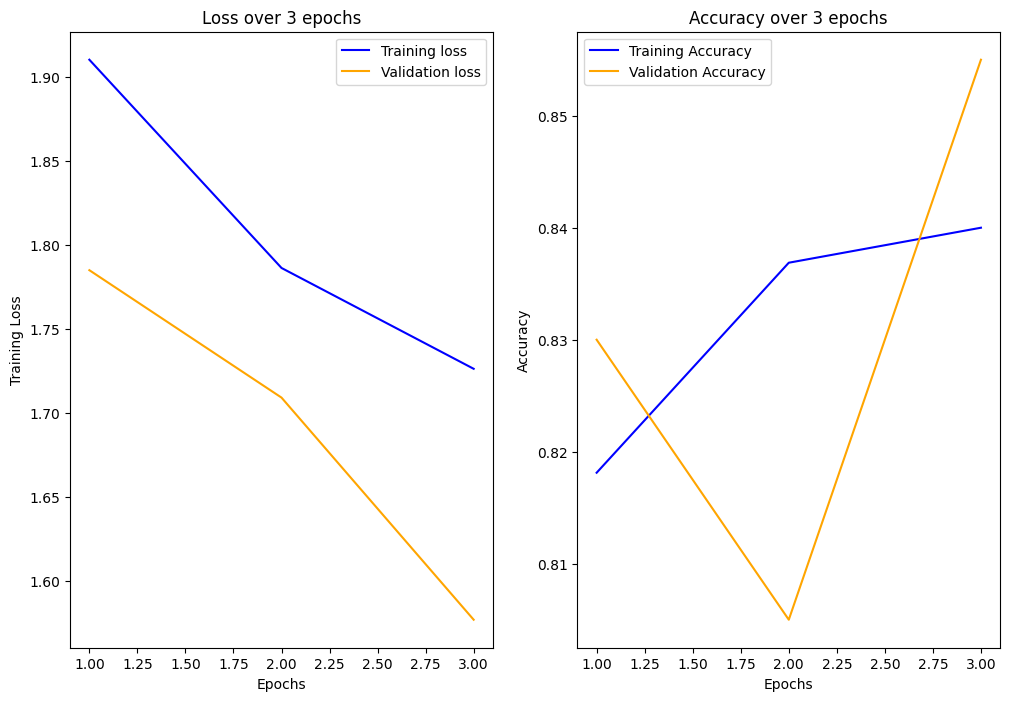

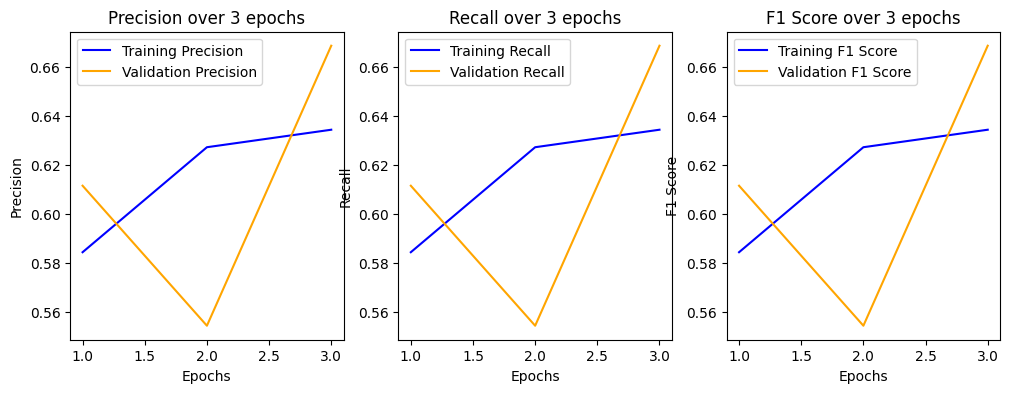

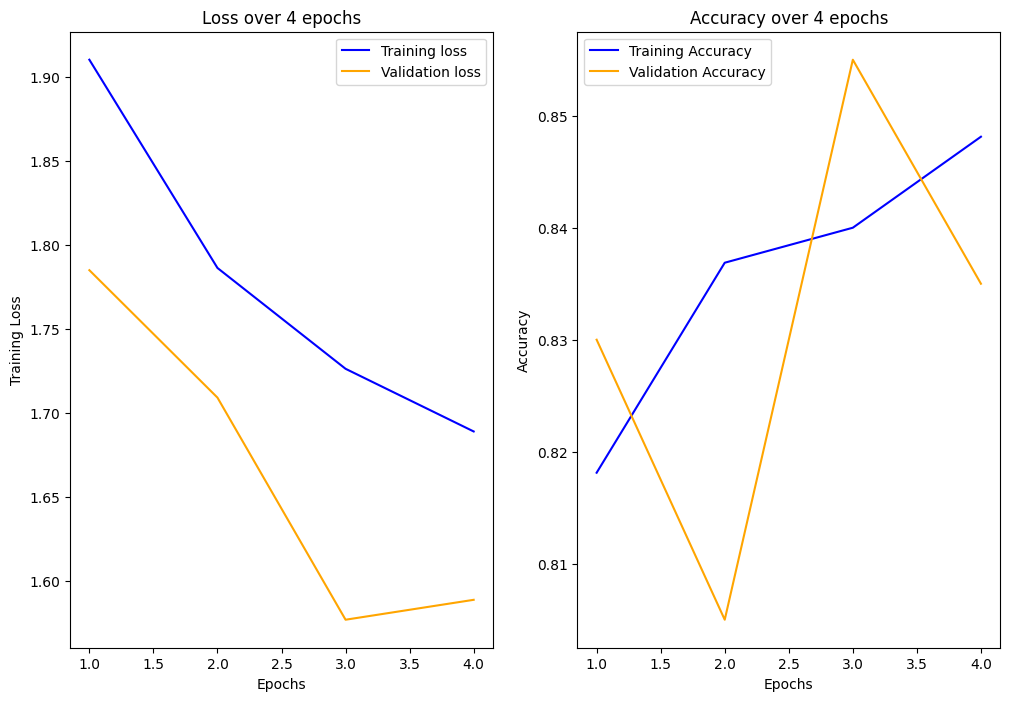

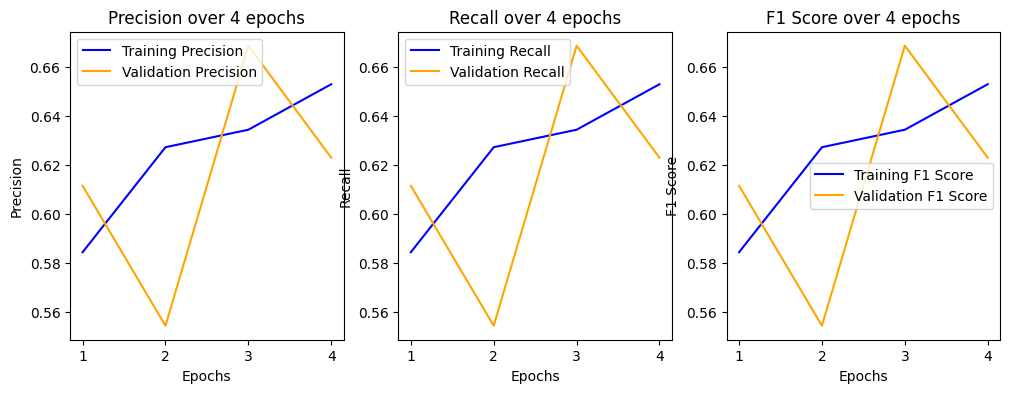

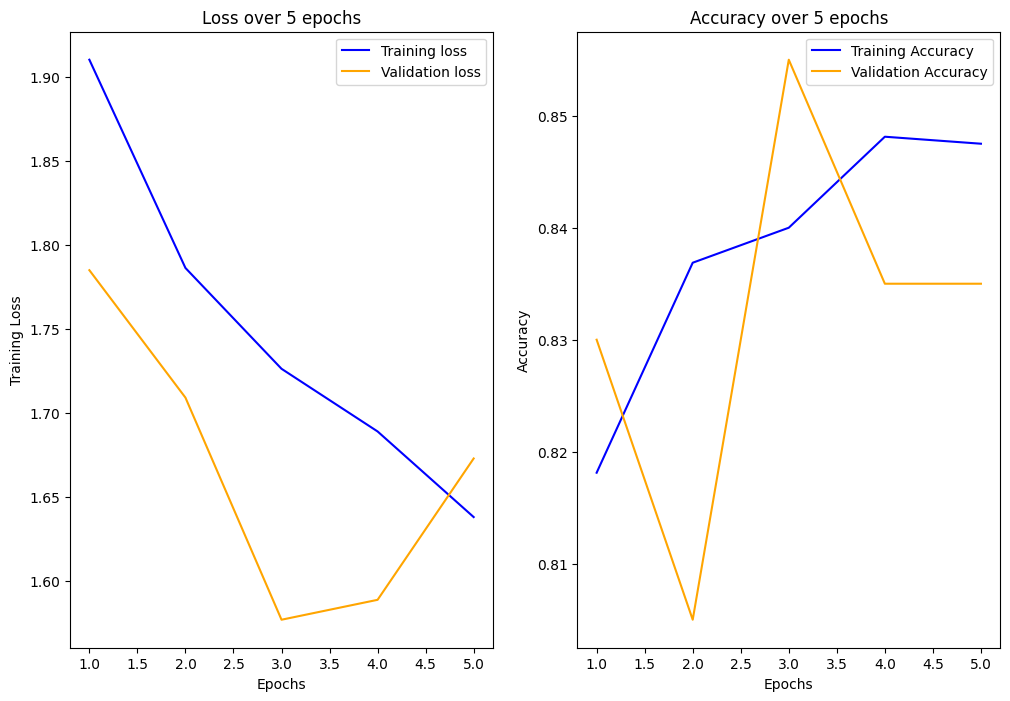

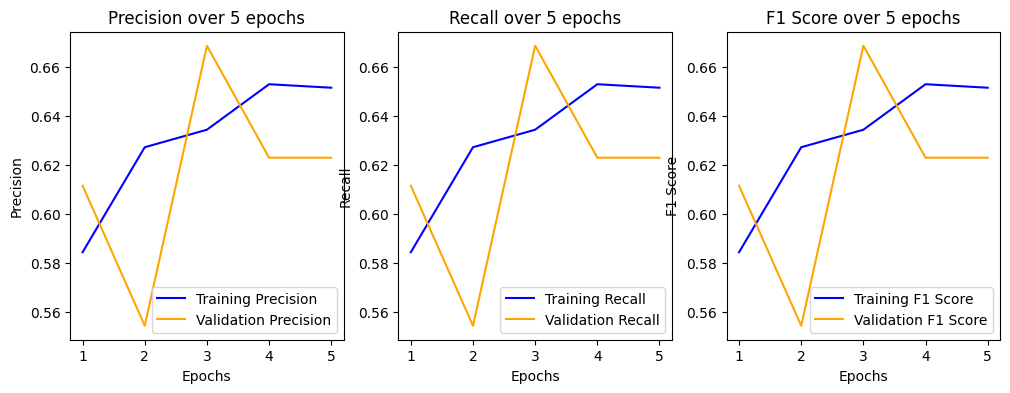

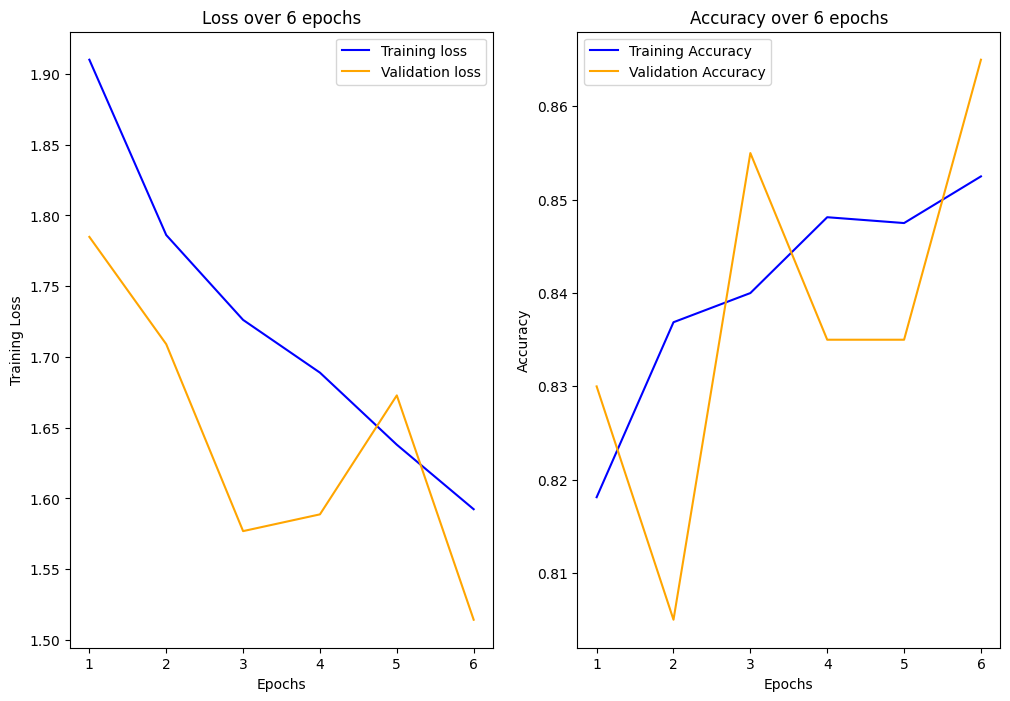

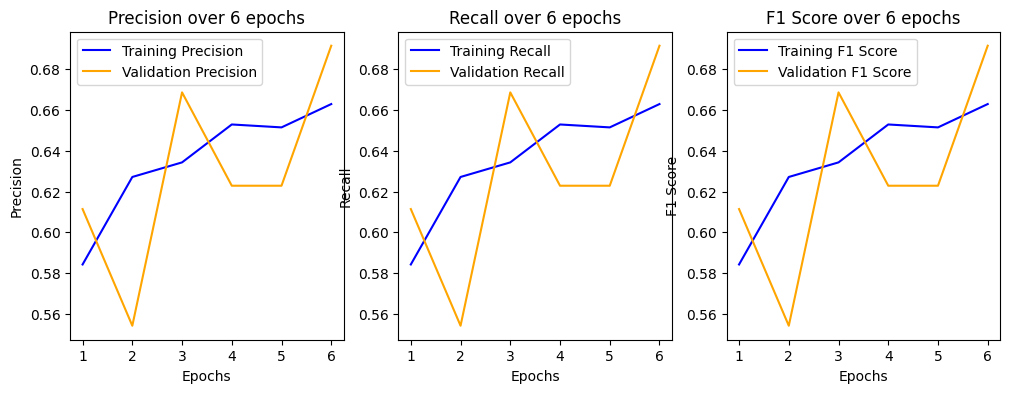

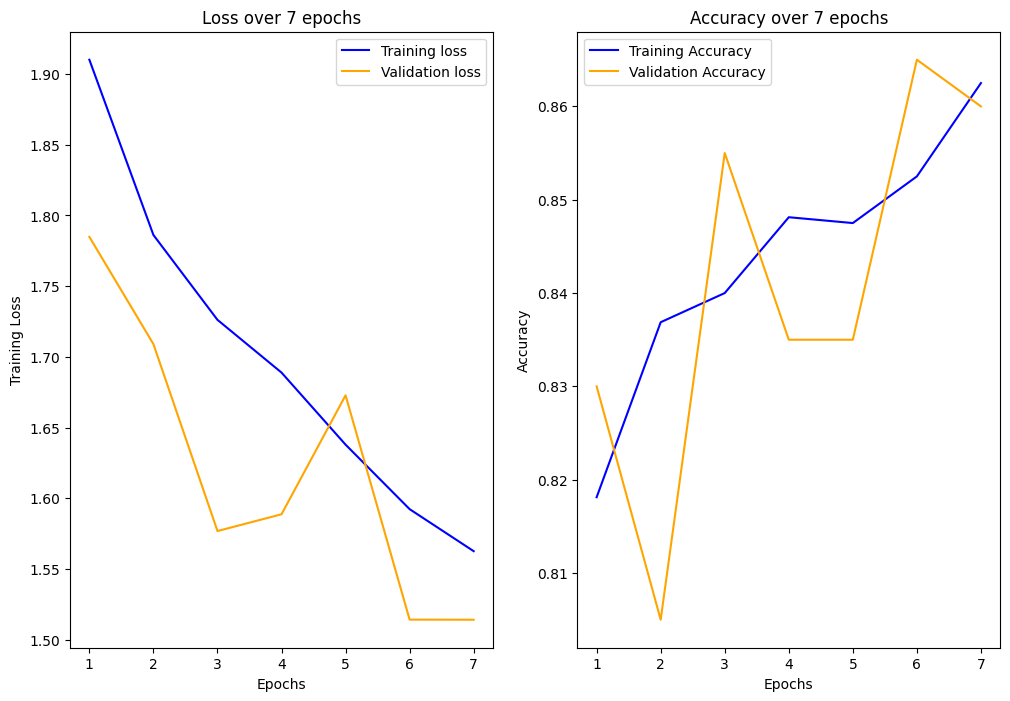

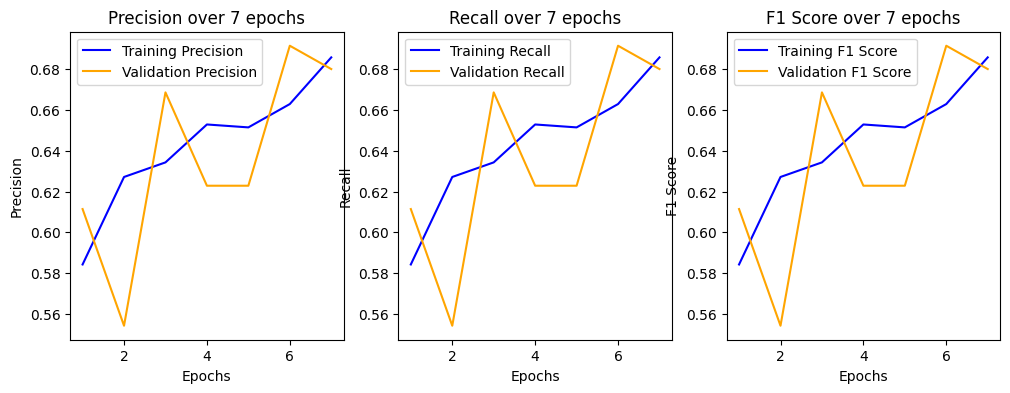

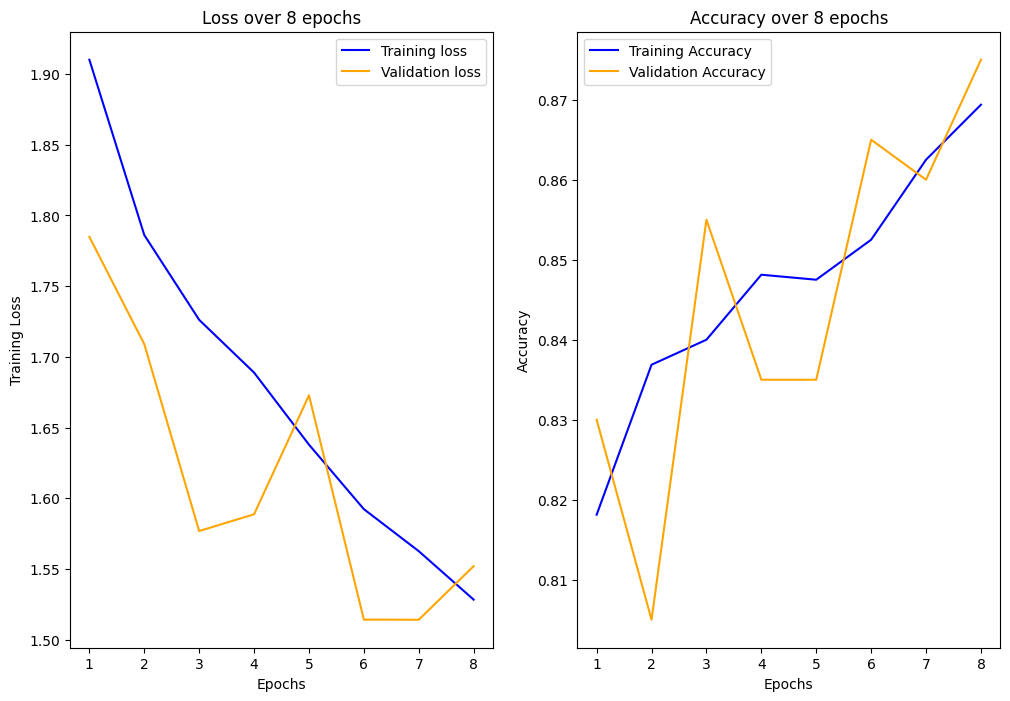

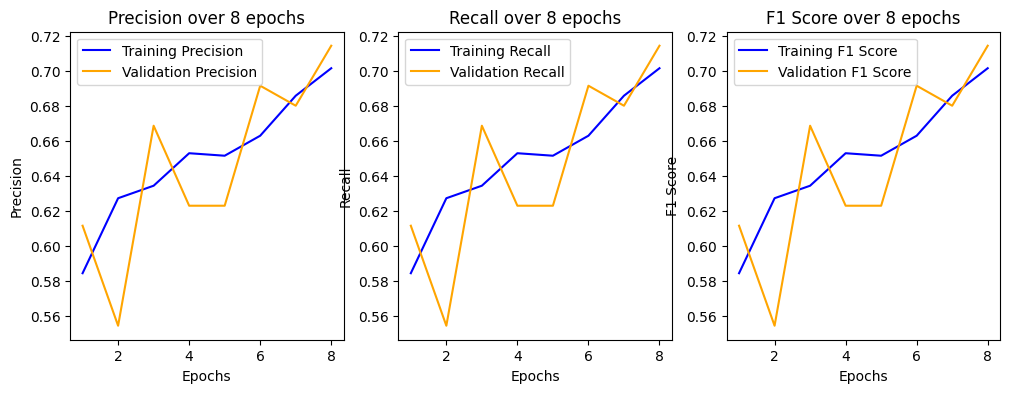

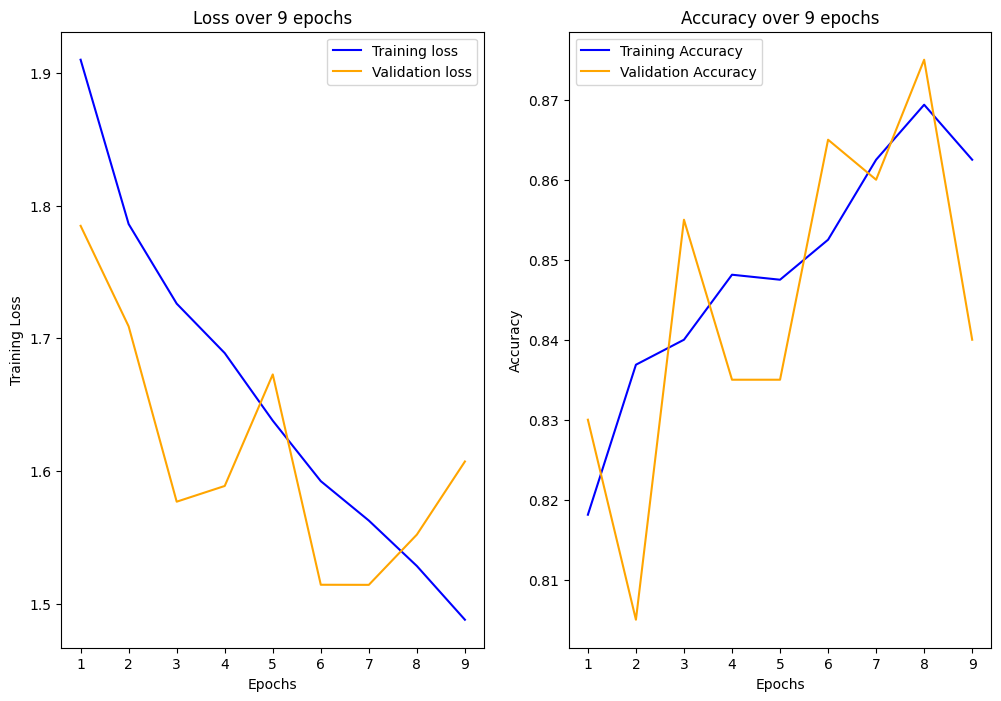

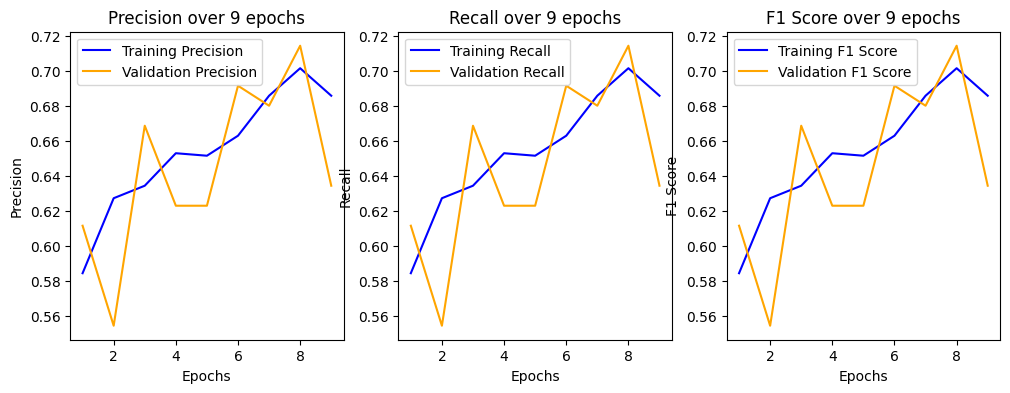

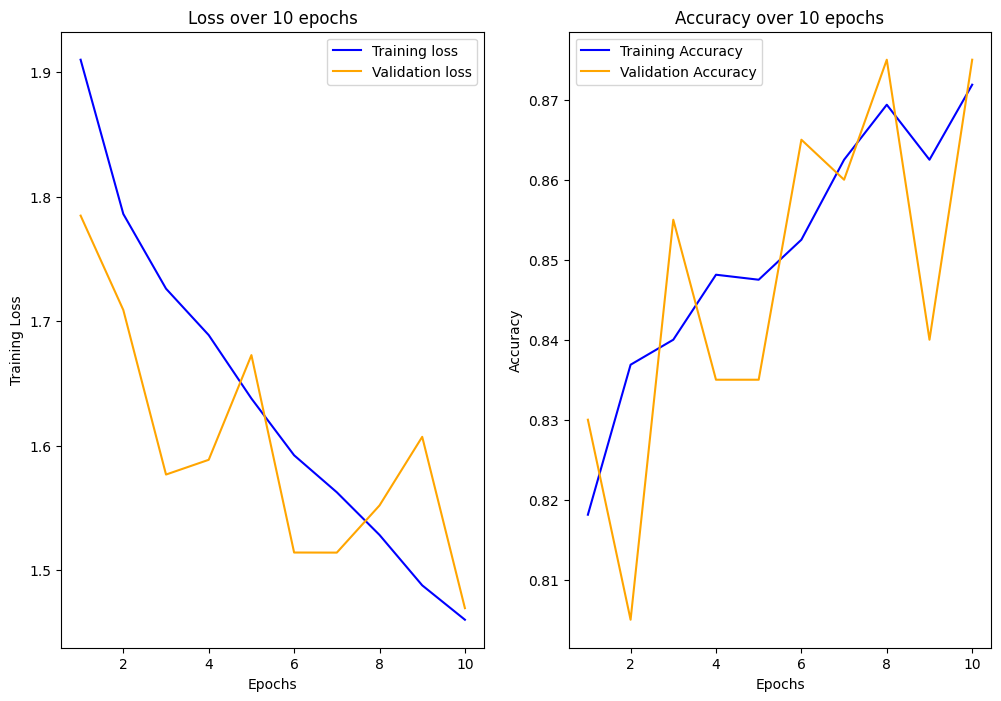

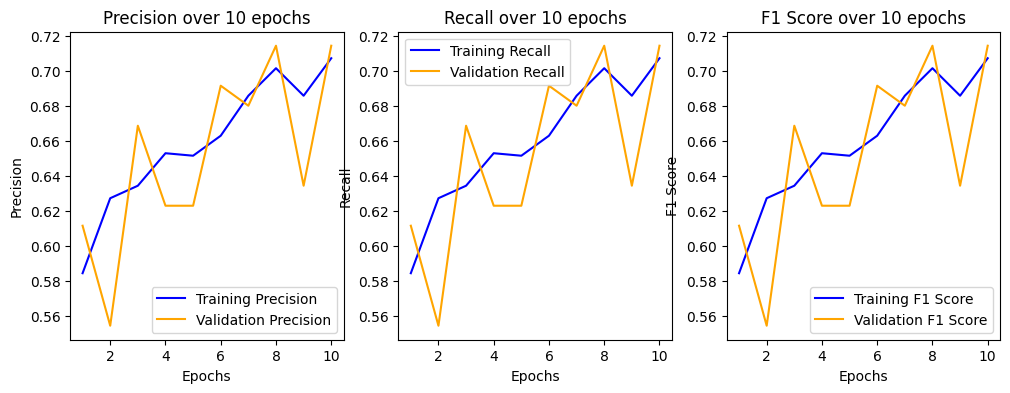

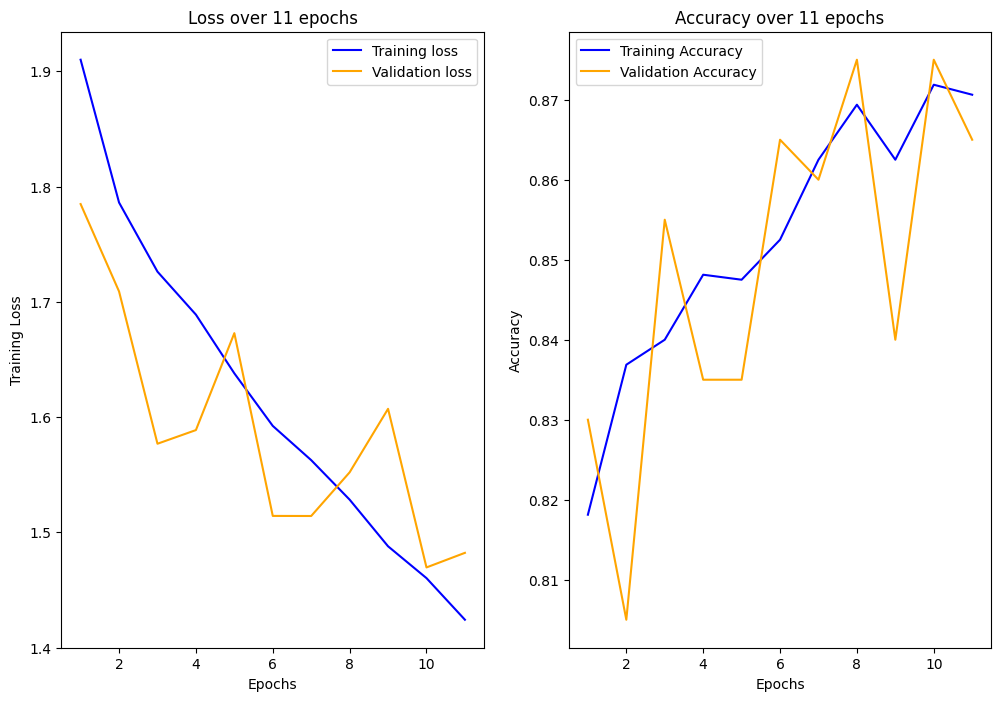

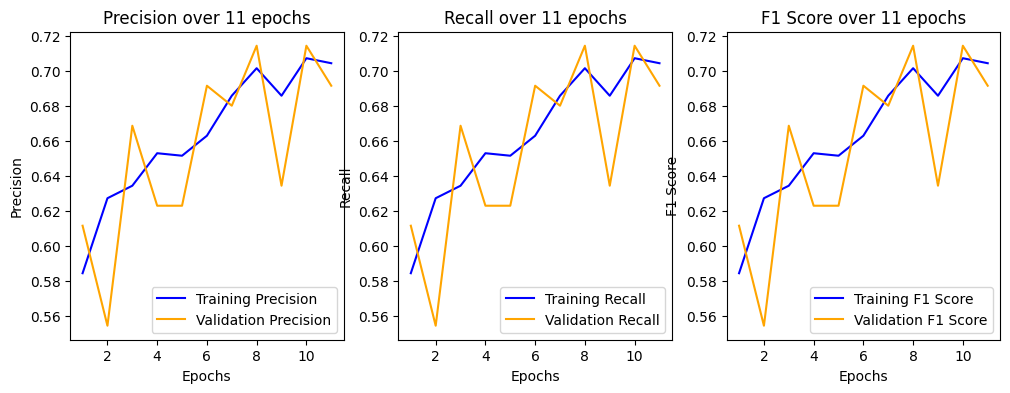

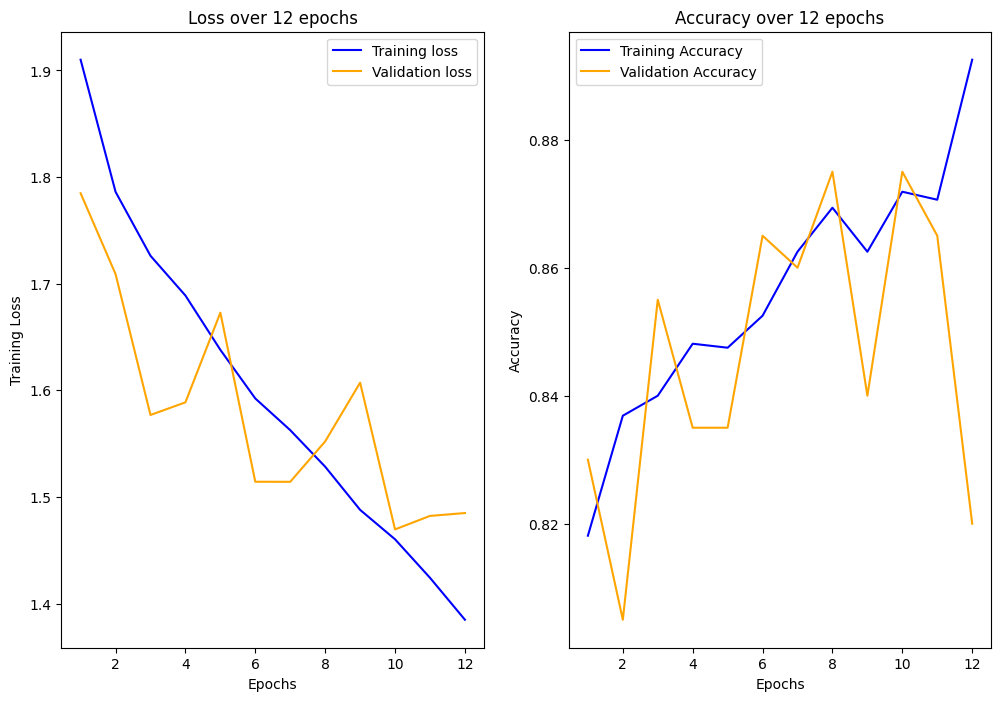

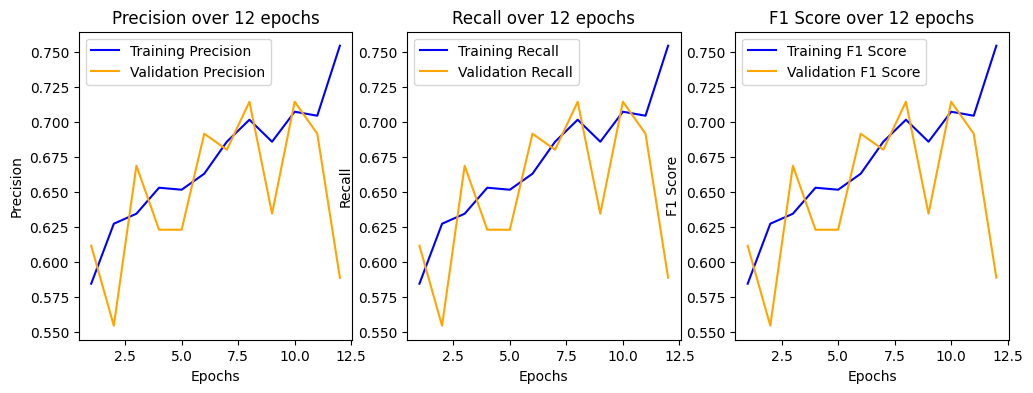

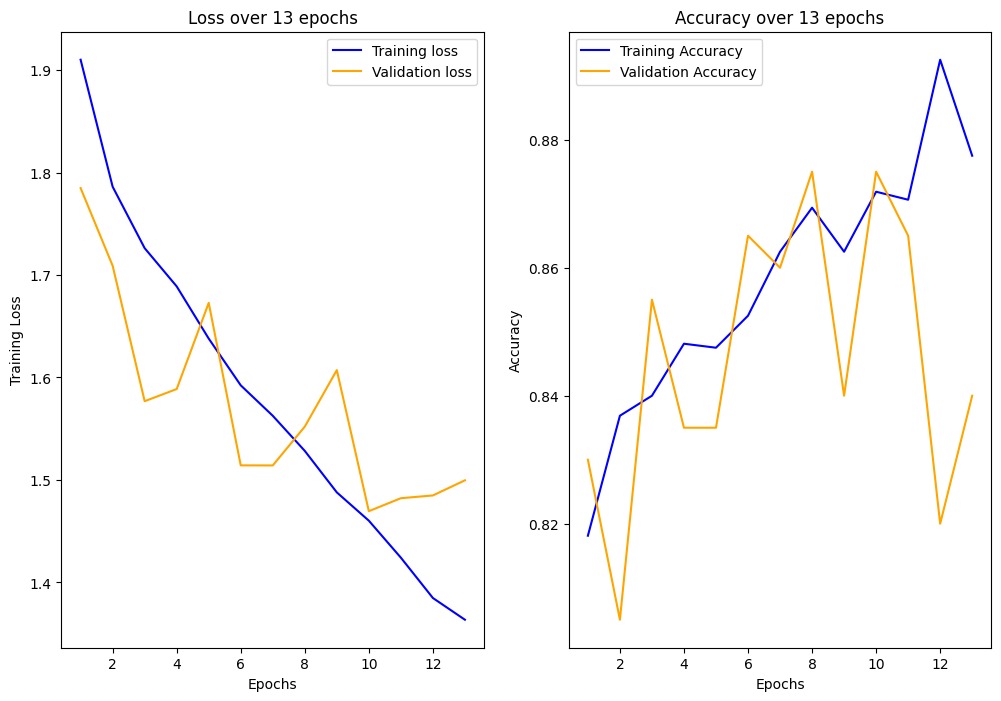

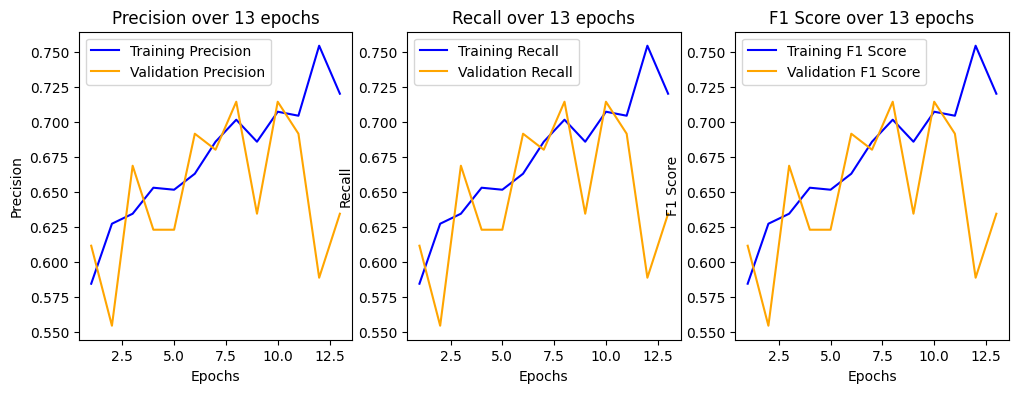

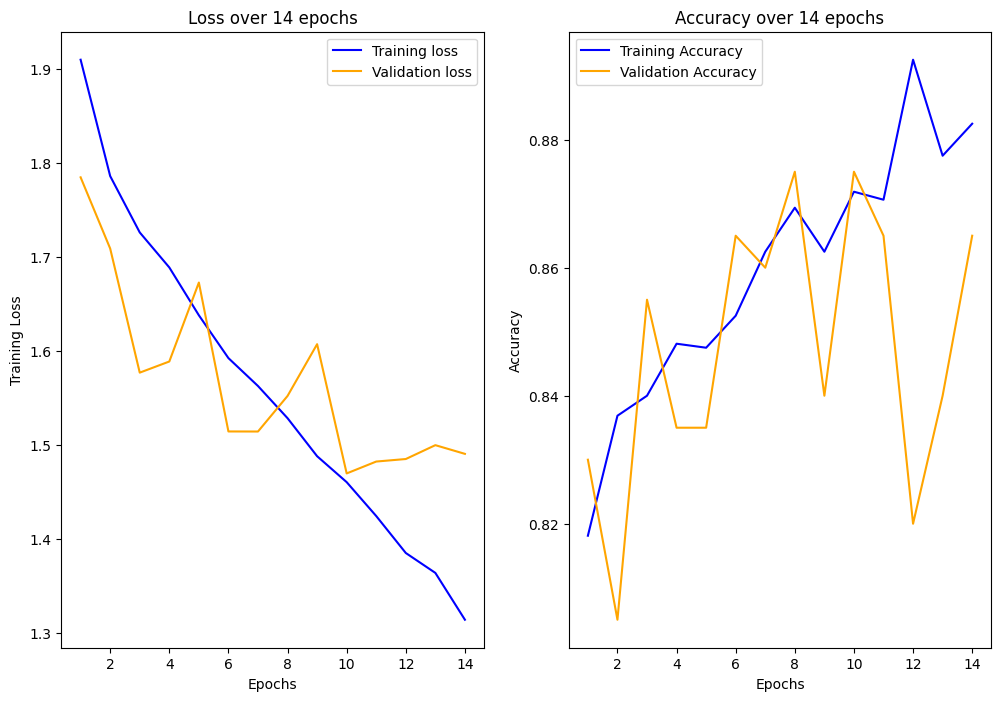

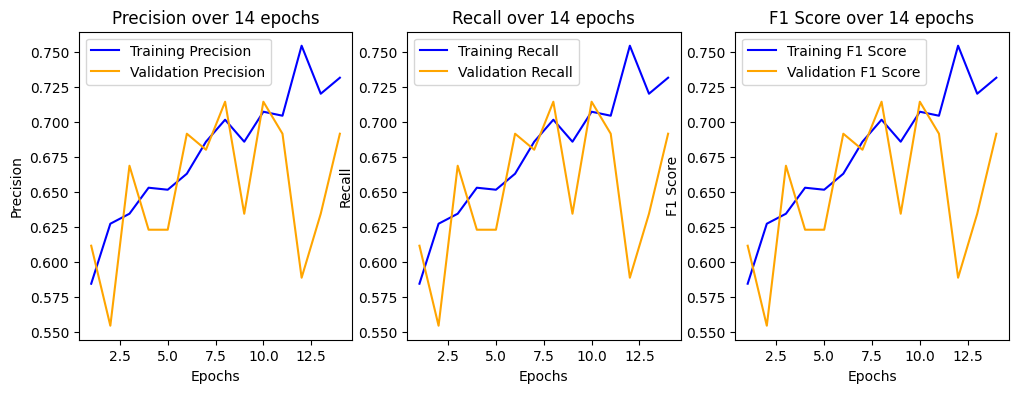

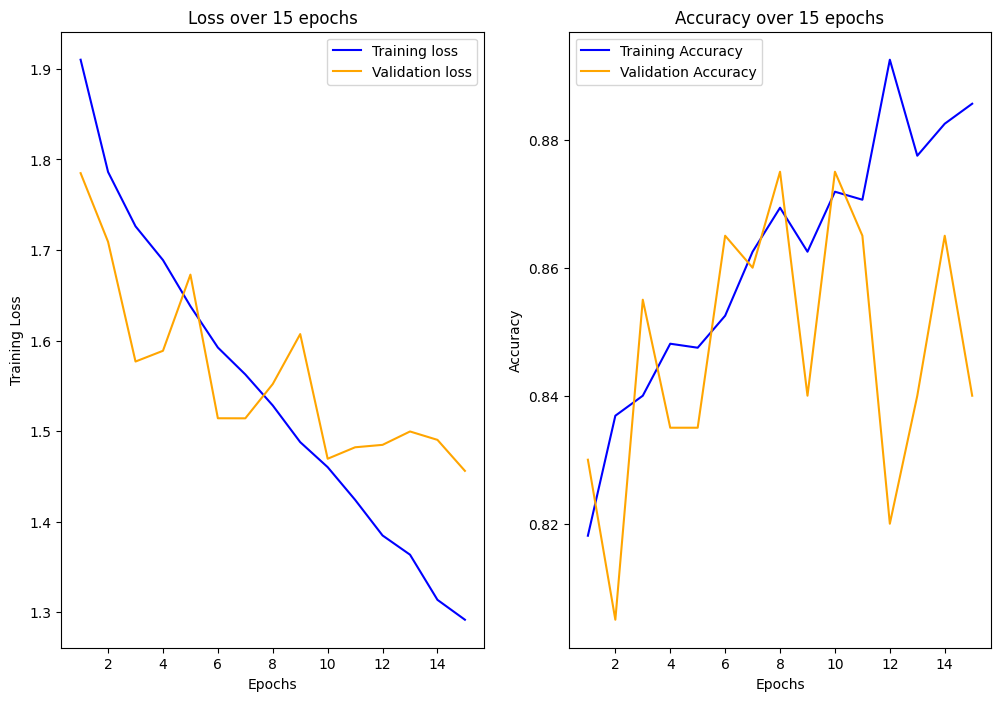

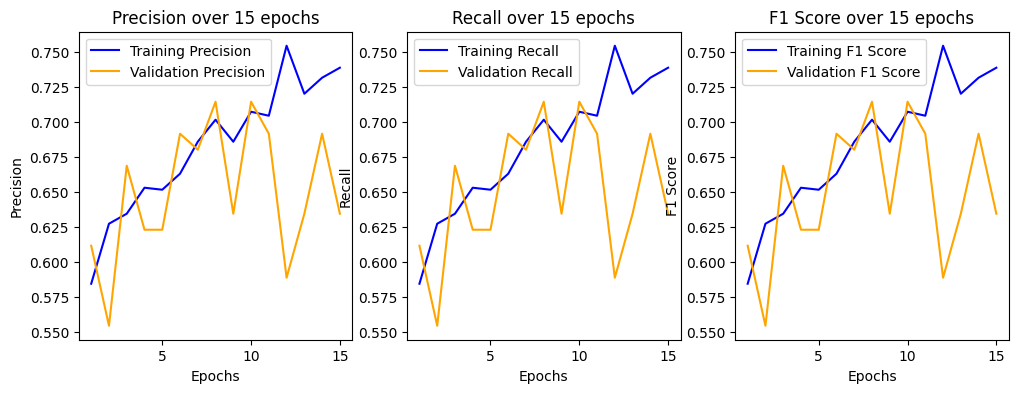

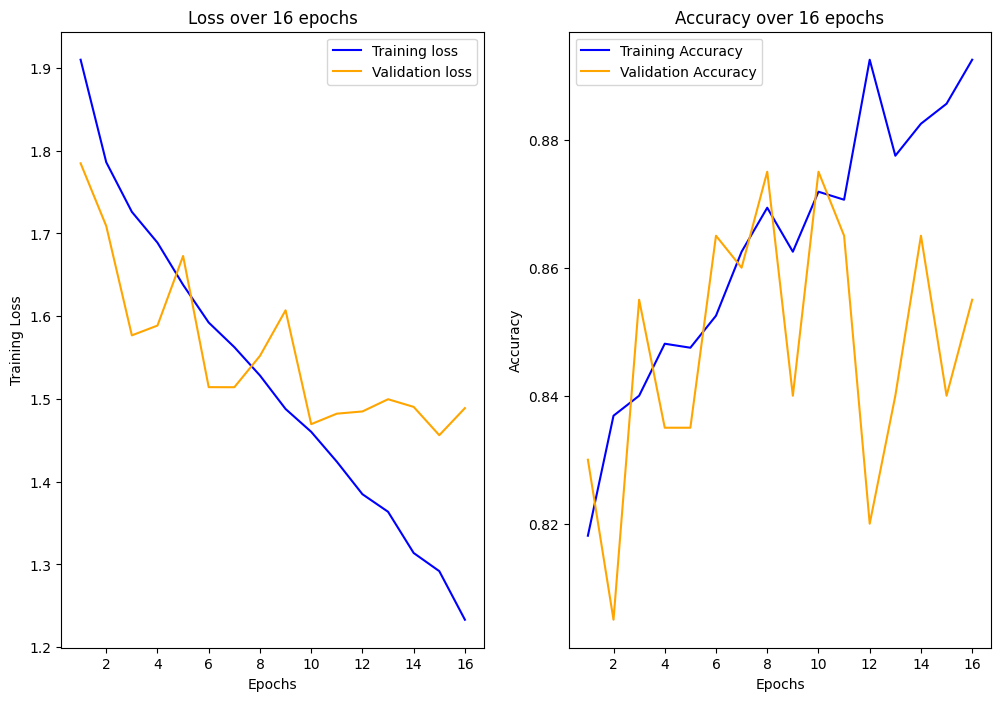

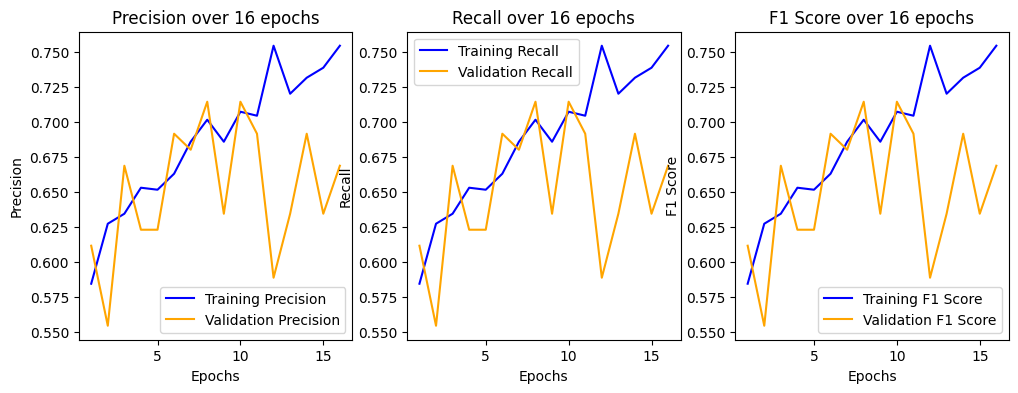

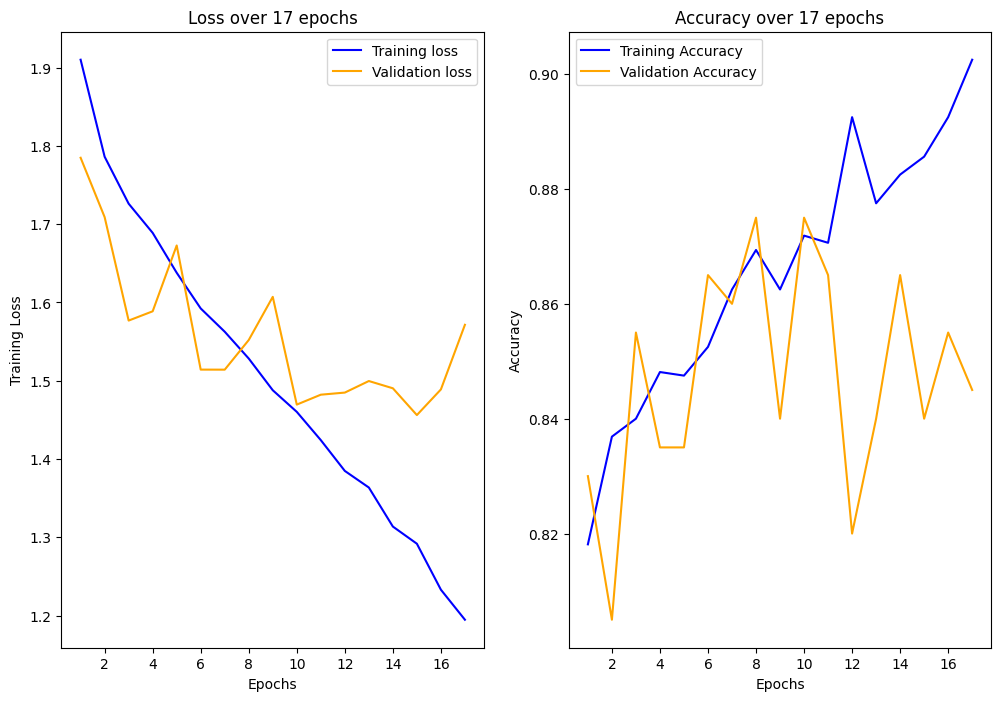

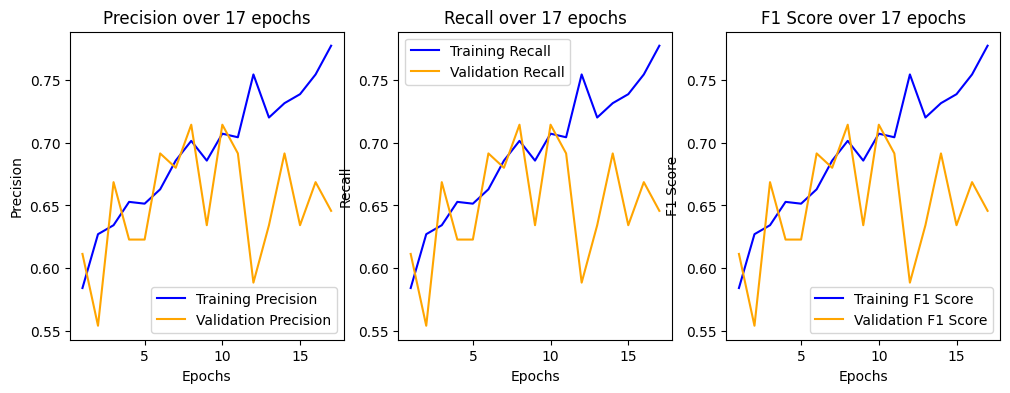

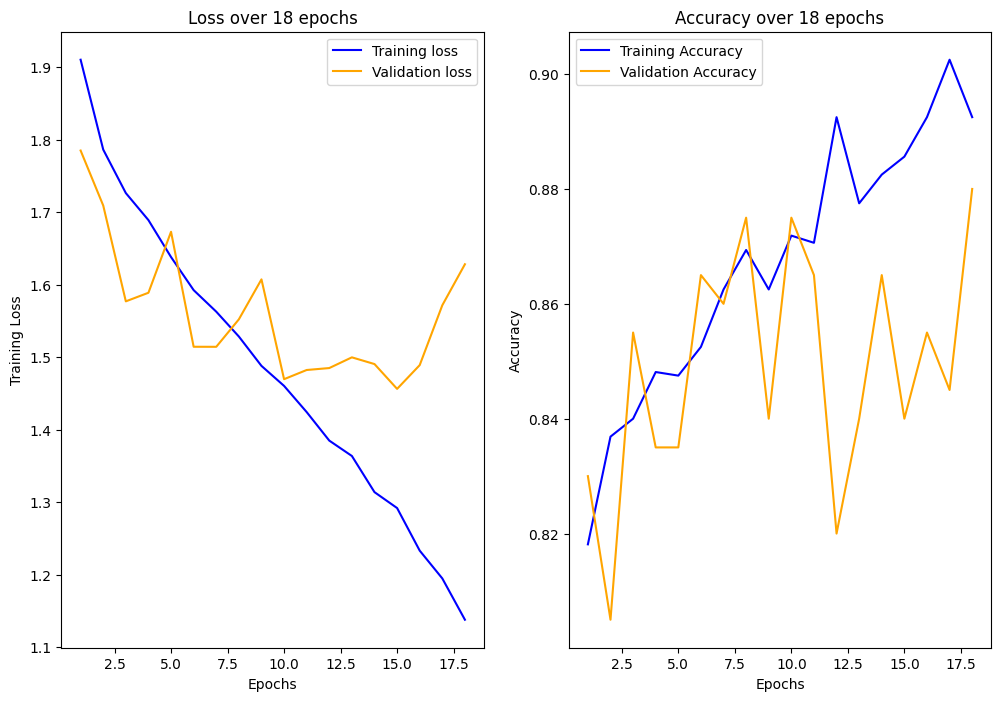

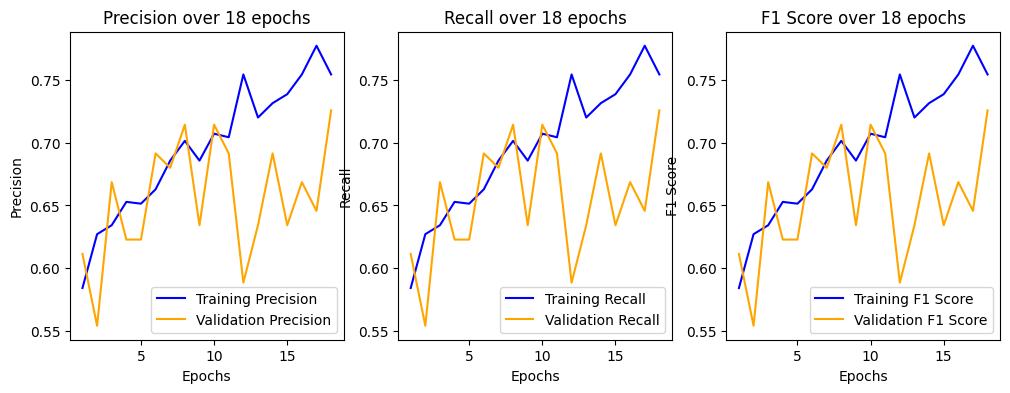

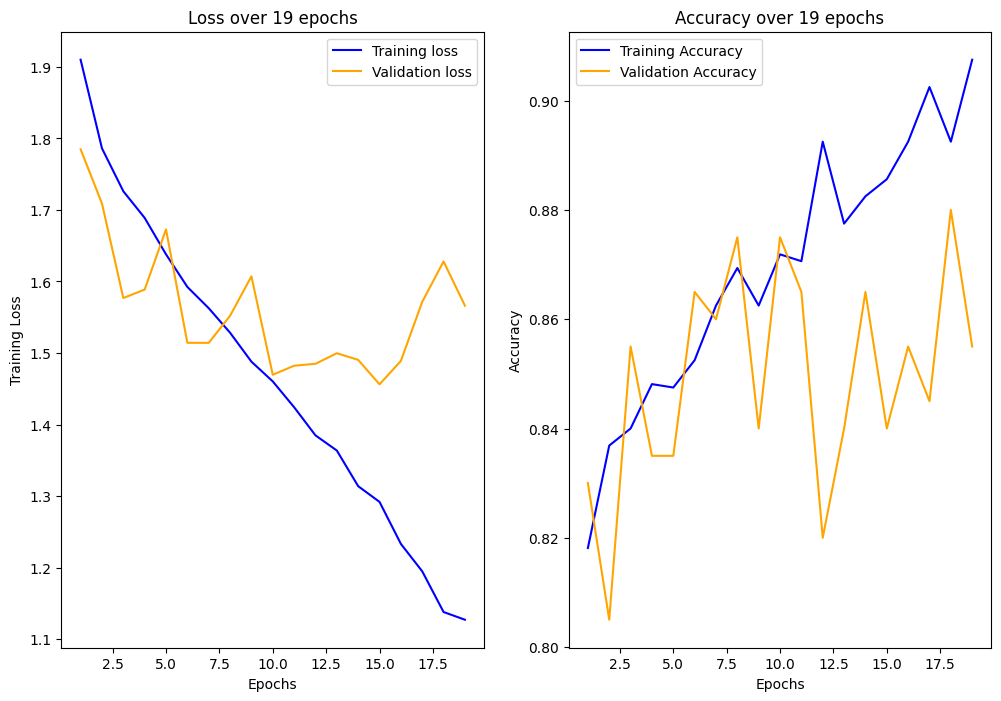

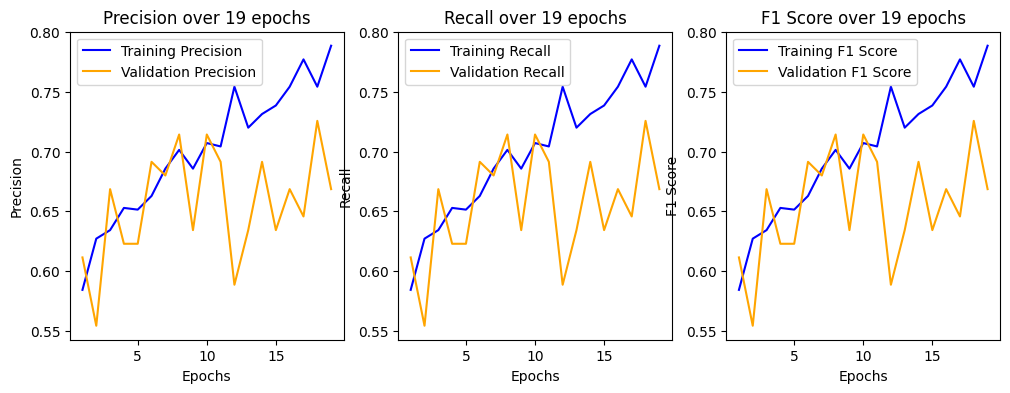

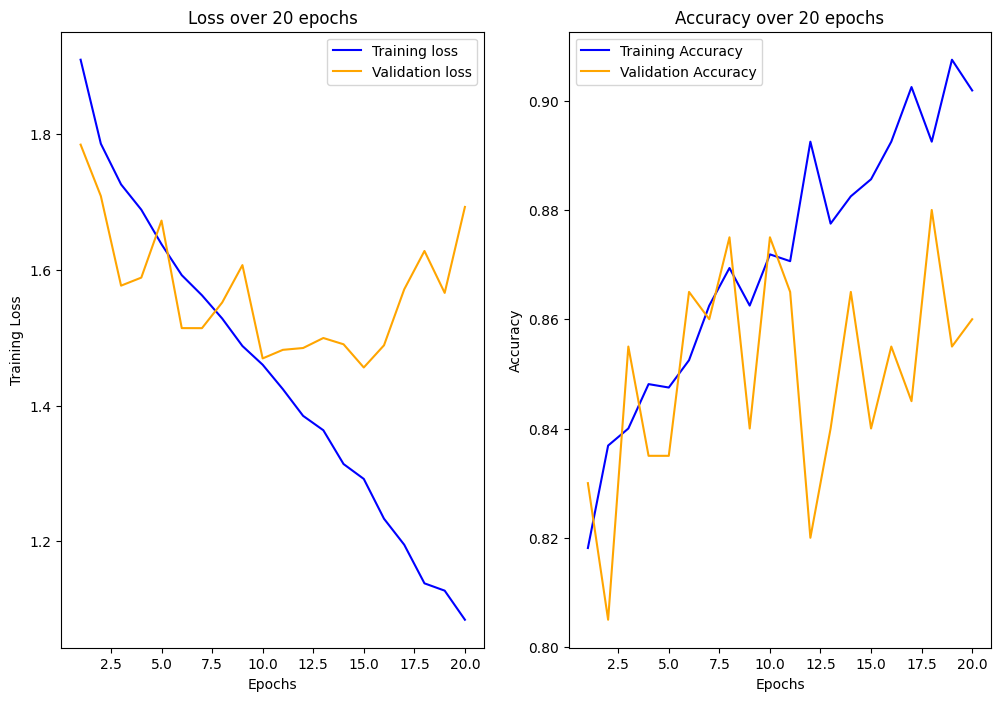

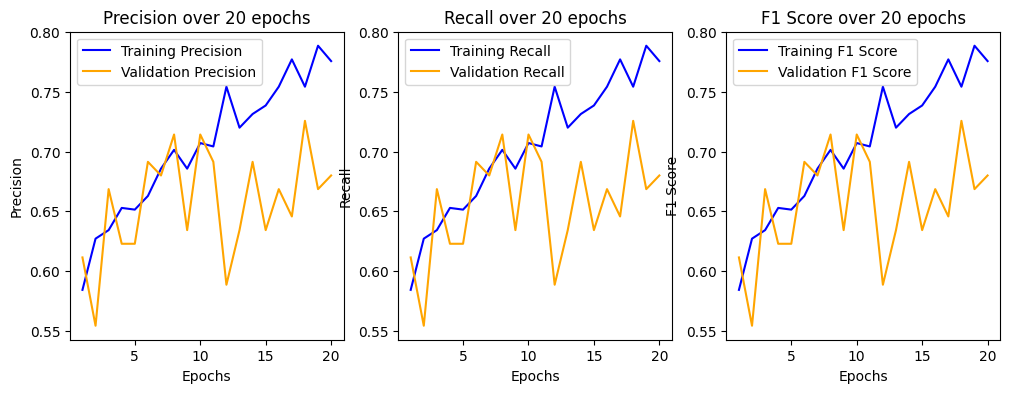

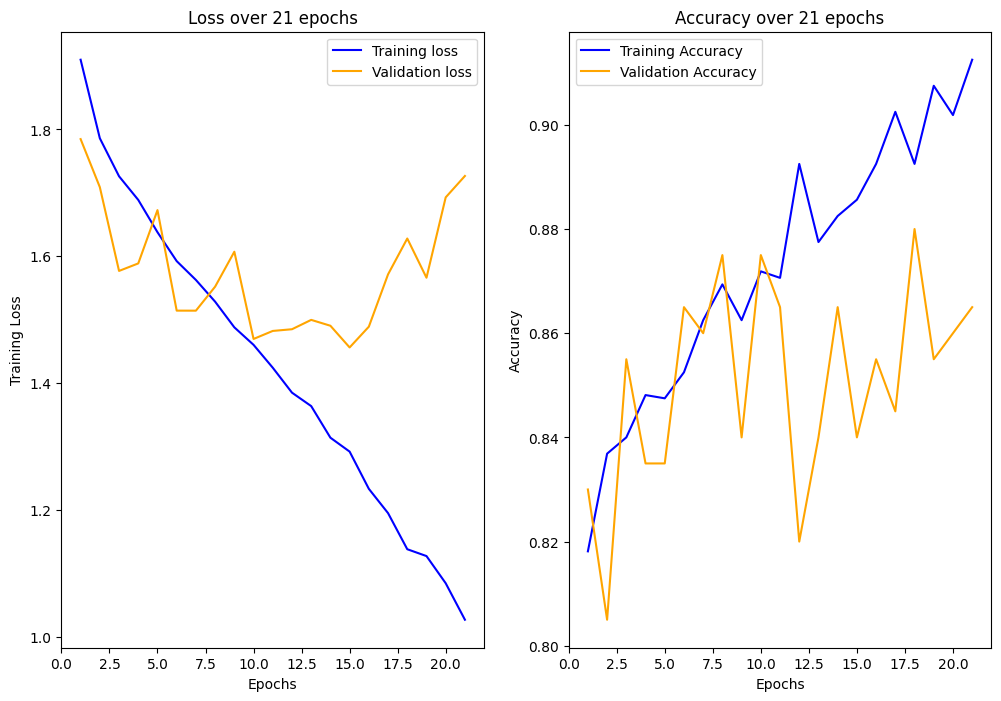

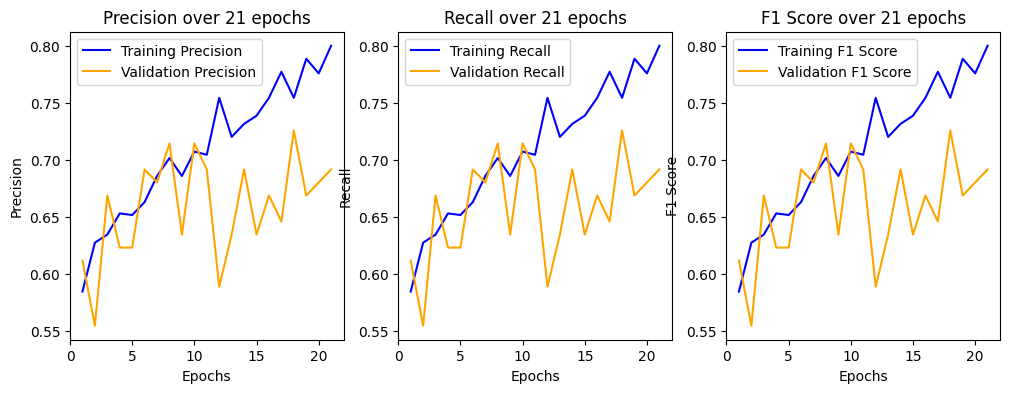

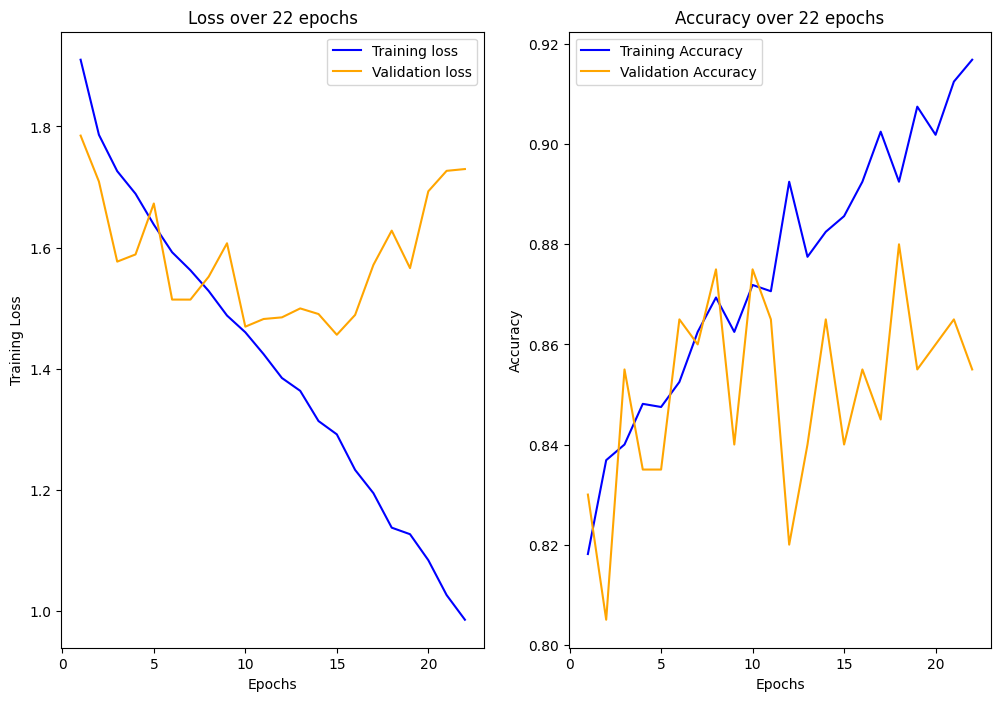

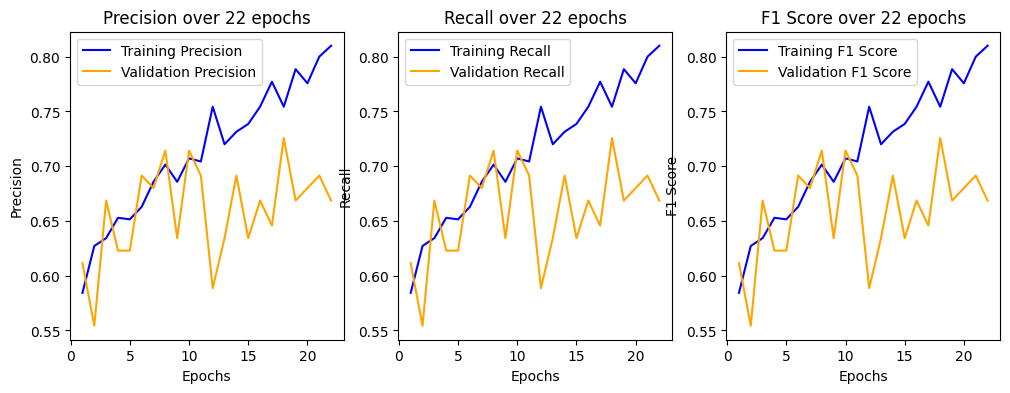

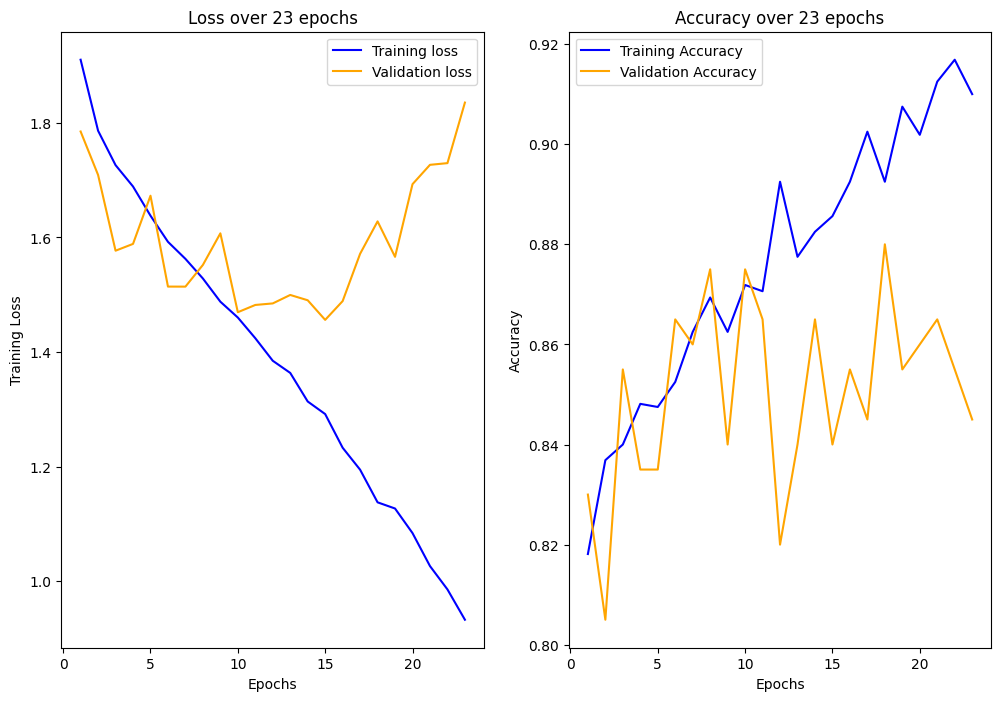

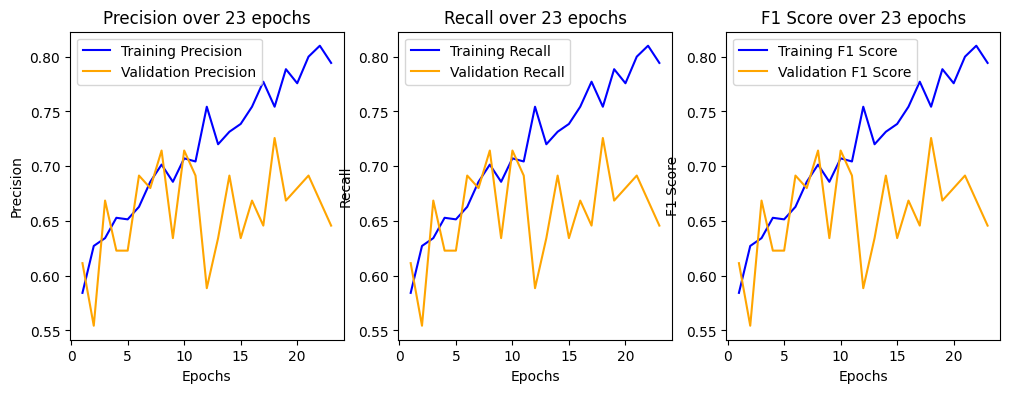

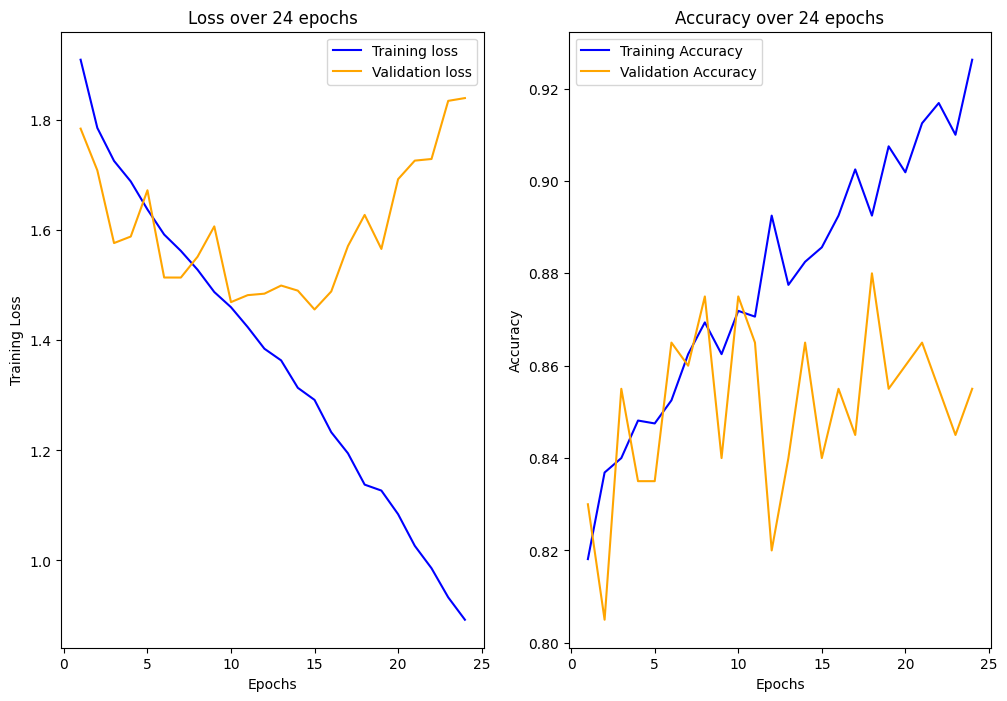

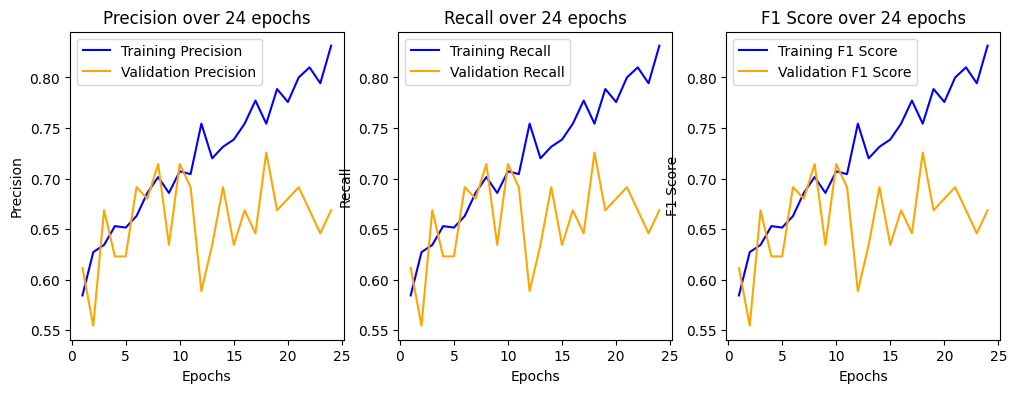

In [ ]:
TRAIN = False

model = CombinedModel()
loss_fn = CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-4)
epochs = 25

if TRAIN: trainingMetricsCombined, evalMetricsCombined = trainModel(model, loss_fn, device, optimizer, epochs, trainDataLoaderCombined, validationDataLoaderCombined) # Both are sorted in order of epochs already

SAVE_RUN = False
SAVE_MODEL = False
if SAVE_RUN:
    torch.save(trainingMetricsCombined, f'{epochs}Run_trainingMetrics_Combined')
    torch.save(evalMetricsCombined, f'{epochs}Run_validationMetrics_Combined')

if SAVE_MODEL:
    torch.save(model.state_dict(), 'CombinedModel')

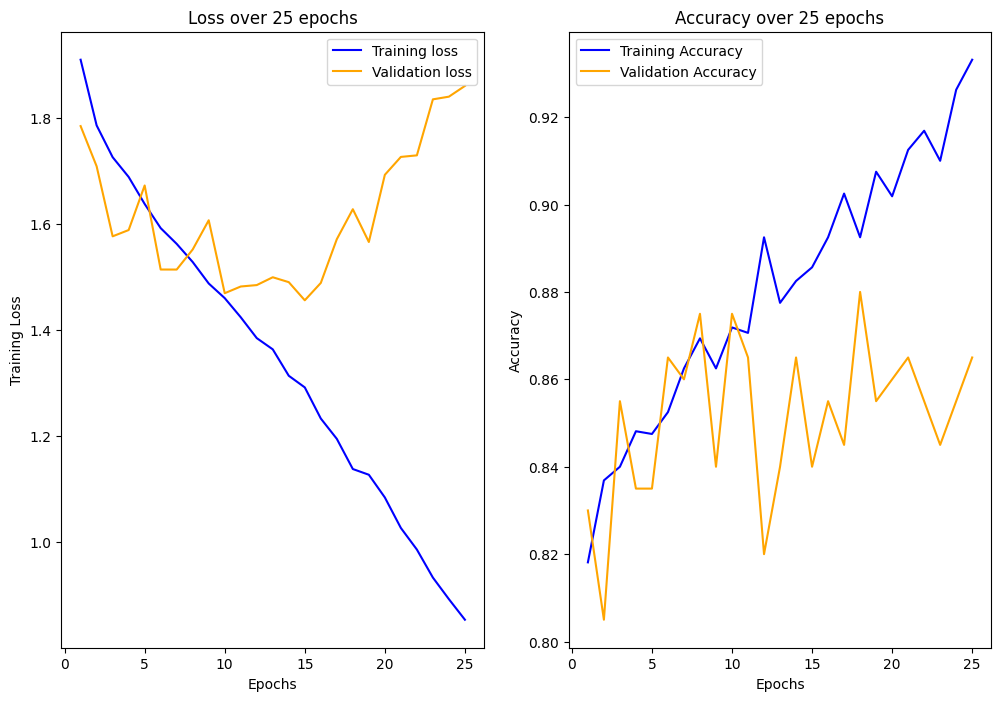

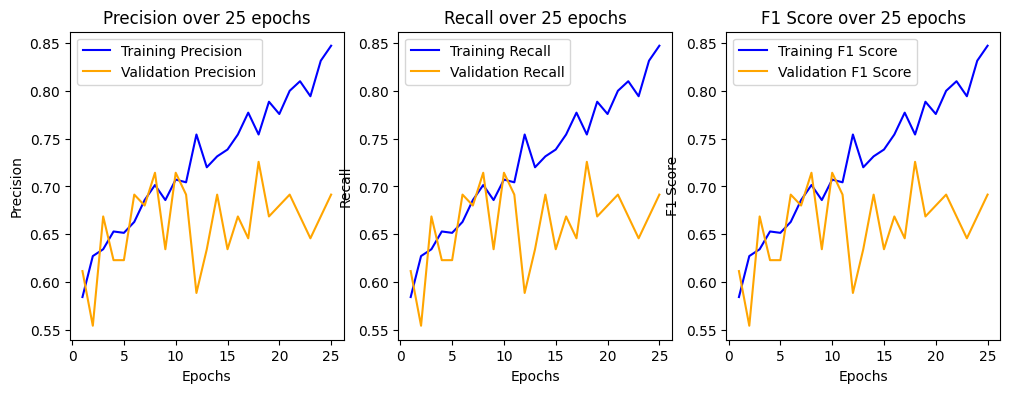

In [ ]:
plotTrainingResults(epochs, trainingMetricsCombined, evalMetricsCombined)

In [ ]:
visualizeResults(model, 'CombinedModel', loss_fn)

cuda


Test loss: 1.1895191669464111:   2%|▏         | 1/50 [00:06<05:05,  6.24s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 1.5780136585235596:   8%|▊         | 4/50 [00:06<00:58,  1.28s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 2.320216178894043:  10%|█         | 5/50 [00:11<01:51,  2.49s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 2.6955487728118896:  12%|█▏        | 6/50 [00:12<01:17,  1.75s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 1.226307988166809:  16%|█▌        | 8/50 [00:13<00:53,  1.26s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 1.8938754796981812:  18%|█▊        | 9/50 [00:18<01:31,  2.24s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 3.591101884841919:  24%|██▍       | 12/50 [00:19<00:48,  1.27s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 2.7547760009765625:  26%|██▌       | 13/50 [00:24<01:16,  2.07s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 1.907572865486145:  28%|██▊       | 14/50 [00:24<00:56,  1.56s/it] 

<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 1.6932154893875122:  32%|███▏      | 16/50 [00:25<00:39,  1.15s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 1.9748194217681885:  34%|███▍      | 17/50 [00:31<01:10,  2.12s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 1.589348554611206:  40%|████      | 20/50 [00:32<00:37,  1.24s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 2.103158950805664:  42%|████▏     | 21/50 [00:36<00:59,  2.05s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 2.2414543628692627:  48%|████▊     | 24/50 [00:37<00:30,  1.17s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 2.284402847290039:  50%|█████     | 25/50 [00:43<00:55,  2.23s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 1.9227365255355835:  54%|█████▍    | 27/50 [00:43<00:29,  1.28s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 2.152721405029297:  56%|█████▌    | 28/50 [00:44<00:26,  1.22s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 2.2673027515411377:  58%|█████▊    | 29/50 [00:49<00:47,  2.25s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 2.194664239883423:  60%|██████    | 30/50 [00:49<00:32,  1.64s/it] 

<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 2.261366367340088:  64%|██████▍   | 32/50 [00:50<00:19,  1.06s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 1.7019312381744385:  66%|██████▌   | 33/50 [00:55<00:34,  2.00s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 2.0466465950012207:  72%|███████▏  | 36/50 [00:56<00:16,  1.17s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 1.5322085618972778:  74%|███████▍  | 37/50 [01:02<00:30,  2.32s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 1.5565216541290283:  78%|███████▊  | 39/50 [01:02<00:14,  1.31s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 2.855374813079834:  80%|████████  | 40/50 [01:02<00:10,  1.03s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 2.9760947227478027:  82%|████████▏ | 41/50 [01:08<00:21,  2.43s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 1.9738564491271973:  86%|████████▌ | 43/50 [01:09<00:09,  1.29s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 1.5606199502944946:  88%|████████▊ | 44/50 [01:09<00:06,  1.06s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 2.694035768508911:  92%|█████████▏| 46/50 [01:17<00:08,  2.15s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 1.7732434272766113:  96%|█████████▌| 48/50 [01:18<00:02,  1.30s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 2.154824733734131:  98%|█████████▊| 49/50 [01:21<00:01,  1.80s/it]

<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>


Test loss: 2.154824733734131: 100%|██████████| 50/50 [01:21<00:00,  1.63s/it]

{'loss': array(2.077422, dtype=float32), 'accuracy': 0.86, 'precision': 0.68, 'recall': 0.68, 'F1Score': 0.68, 'confusionMatrix': array([[322,  28],
       [ 28,  22]])}


## Results and Conclusion

In [ ]:
def visualizeResults(model, modelSaveState, loss_fn):
    # Takes in a model, loads it and prints out metrics

    model.load_state_dict(torch.load(modelSaveState))
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    testMetrics1D = testModel(model, loss_fn, device, testDataLoader)
    print(testMetrics1D)

model = TwoDModel()
model.load_state_dict(torch.load('TwoDModel_running_15s'))
model.to(device)




NameError: ignored

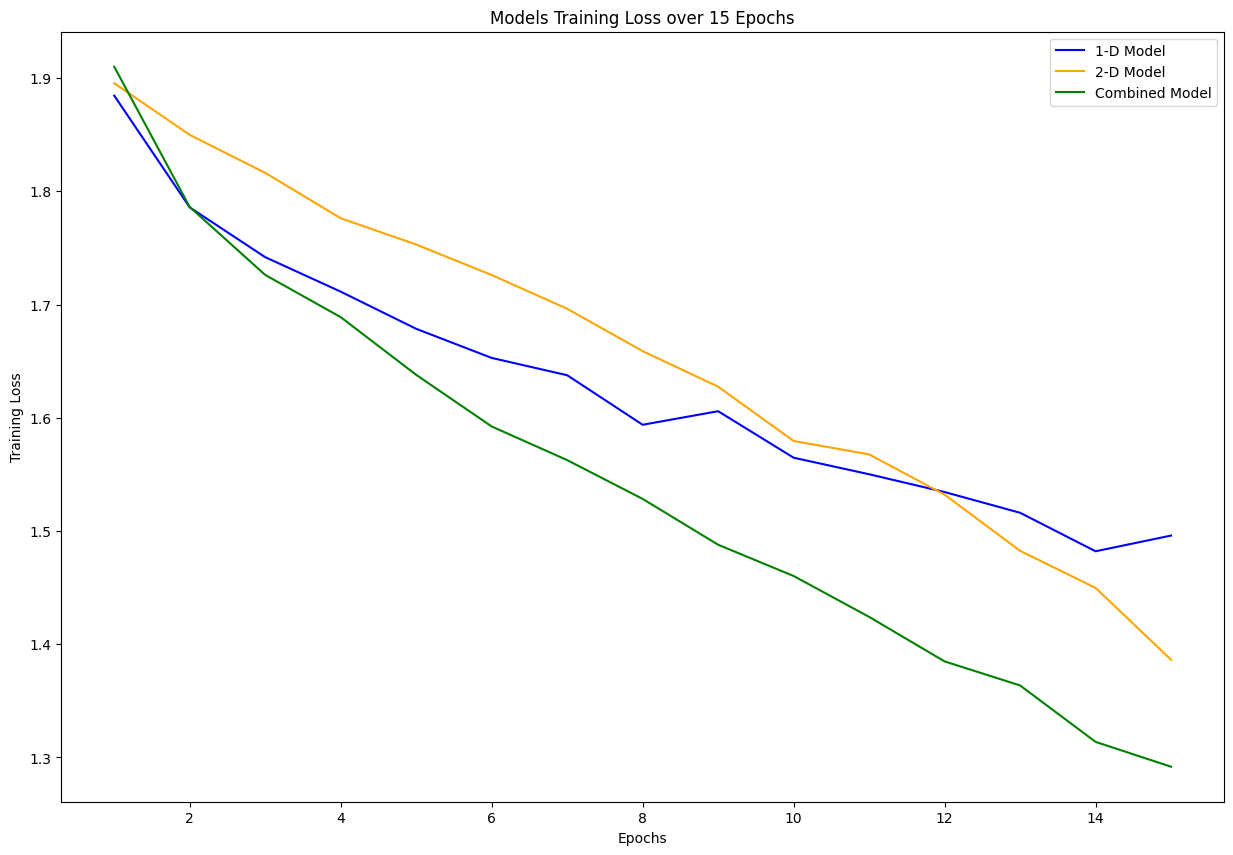

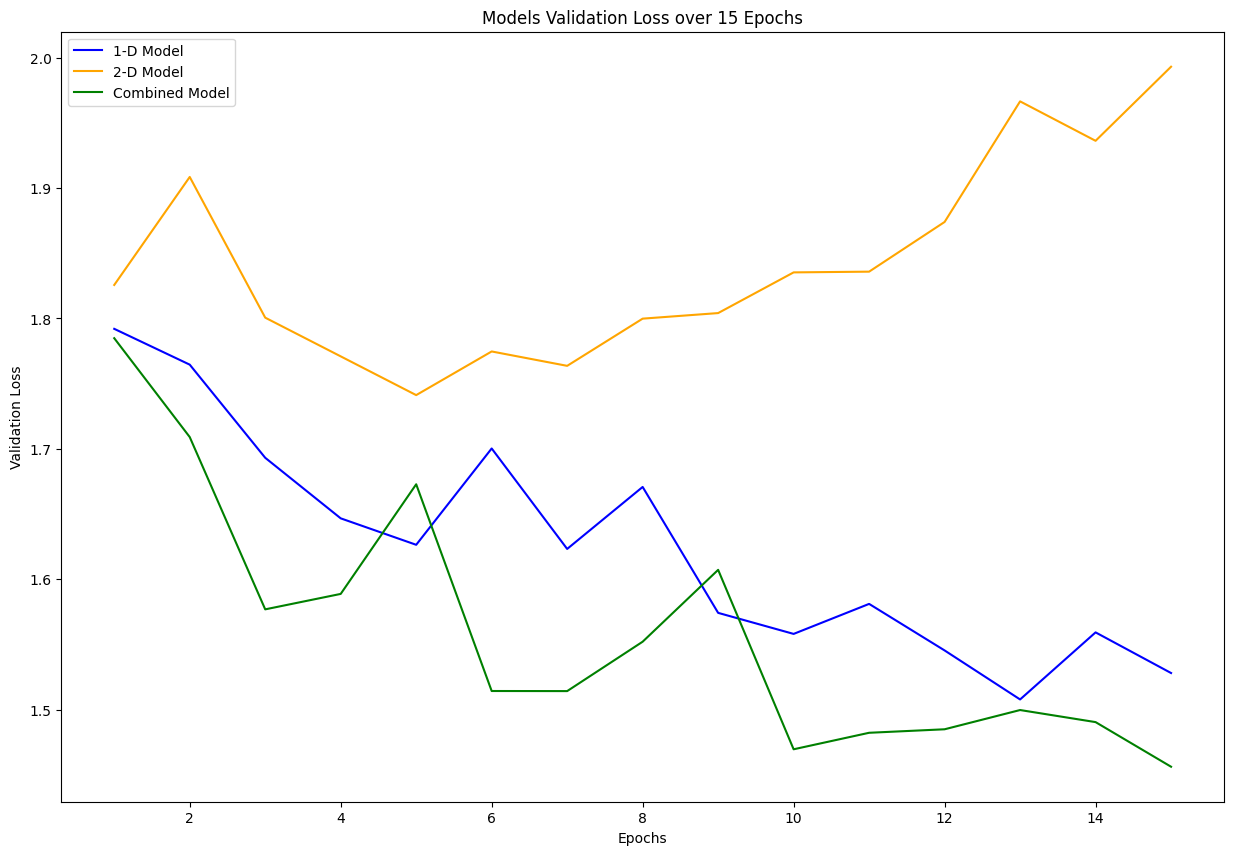

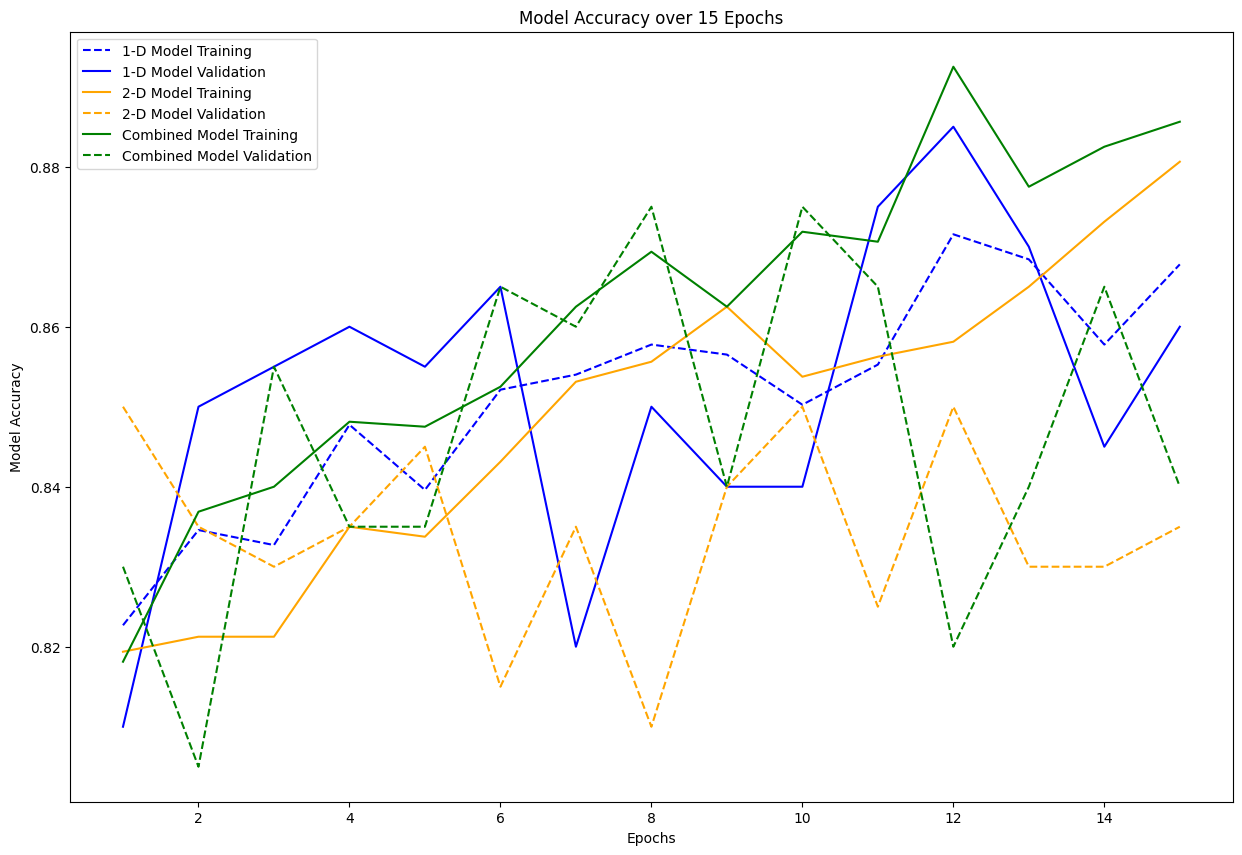

In [ ]:
%matplotlib inline
def plotModelsComparision(epochs, model1DMetrics, model2DMetrics, combinedModelMetrics):
    # For each model that have been run, plot their loss over epochs and accuracy over epochs to compare

    fig1, axes1 = plt.subplots(1, 1, figsize=(15, 10))

    # Plot training loss over epochs
    model1DTrainLoss = dictToArray(model1DMetrics[0], 'loss')[:epochs]
    model2DTrainLoss = dictToArray(model2DMetrics[0], 'loss')[:epochs]
    combinedModelTrainLoss = dictToArray(combinedModelMetrics[0], 'loss')[:epochs]
    axes1.plot(range(1, epochs+1), model1DTrainLoss, label='1-D Model', color='blue')
    axes1.plot(range(1, epochs+1), model2DTrainLoss, label='2-D Model', color='orange')
    axes1.plot(range(1, epochs+1), combinedModelTrainLoss, label='Combined Model', color='green')
    axes1.set_title(f'Models Training Loss over {epochs} Epochs')
    axes1.set_xlabel('Epochs')
    axes1.set_ylabel('Training Loss')
    axes1.legend()
    fig1.savefig('figures/TrainLoss_over_Epochs')

    fig2, axes2 = plt.subplots(1, 1, figsize=(15, 10))

    # Plot validation loss over epochs
    model1DValLoss = dictToArray(model1DMetrics[1], 'loss')[:epochs]
    model2DValLoss = dictToArray(model2DMetrics[1], 'loss')[:epochs]
    combinedModelValLoss = dictToArray(combinedModelMetrics[1], 'loss')[:epochs]
    axes2.plot(range(1, epochs+1), model1DValLoss, label='1-D Model', color='blue')
    axes2.plot(range(1, epochs+1), model2DValLoss, label='2-D Model', color='orange')
    axes2.plot(range(1, epochs+1), combinedModelValLoss, label='Combined Model', color='green')
    axes2.set_title(f'Models Validation Loss over {epochs} Epochs')
    axes2.set_xlabel('Epochs')
    axes2.set_ylabel('Validation Loss')
    axes2.legend()
    fig2.savefig('figures/ValLoss_over_Epochs')

    fig3, axes3 = plt.subplots(1, 1, figsize=(15, 10))

    # Plot accuracy over epochs
    model1DTrainAcc = dictToArray(model1DMetrics[0], 'accuracy')[:epochs]
    model1DValAcc = dictToArray(model1DMetrics[1], 'accuracy')[:epochs]
    model2DTrainAcc = dictToArray(model2DMetrics[0], 'accuracy')[:epochs]
    model2DValAcc = dictToArray(model2DMetrics[1], 'accuracy')[:epochs]
    combinedModelTrainAcc = dictToArray(combinedModelMetrics[0], 'accuracy')[:epochs]
    combinedModelValAcc = dictToArray(combinedModelMetrics[1], 'accuracy')[:epochs]
    axes3.plot(range(1, epochs+1), model1DTrainAcc, '--', label='1-D Model Training', color='blue')
    axes3.plot(range(1, epochs+1), model1DValAcc, label='1-D Model Validation', color='blue')
    axes3.plot(range(1, epochs+1), model2DTrainAcc, label='2-D Model Training', color='orange')
    axes3.plot(range(1, epochs+1), model2DValAcc, '--', label='2-D Model Validation', color='orange')
    axes3.plot(range(1, epochs+1), combinedModelTrainAcc, label='Combined Model Training', color='green')
    axes3.plot(range(1, epochs+1), combinedModelValAcc, '--', label='Combined Model Validation', color='green')
    axes3.set_title(f'Model Accuracy over {epochs} Epochs')
    axes3.set_xlabel('Epochs')
    axes3.set_ylabel('Model Accuracy')
    axes3.legend()
    fig3.savefig('figures/Accuracy_over_epochs.png')


model1DTrainMetrics, model1DValMetrics = torch.load('35Run_trainingMetrics_1D'), torch.load('35Run_validationMetrics_1D')
model1DMetrics = [model1DTrainMetrics, model1DValMetrics]
model2DTrainMetrics, model2DValMetrics = torch.load('15Run_trainingMetrics_2D'), torch.load('15Run_validationMetrics_2D')
model2DMetrics = [model2DTrainMetrics, model2DValMetrics]
modelCombinedTrainMetrics, modelCombinedValMetrics = torch.load('25Run_trainingMetrics_Combined'), torch.load('25Run_validationMetrics_Combined')
modelCombinedMetrics = [modelCombinedTrainMetrics, modelCombinedValMetrics]

plotModelsComparision(15, model1DMetrics, model2DMetrics, modelCombinedMetrics)

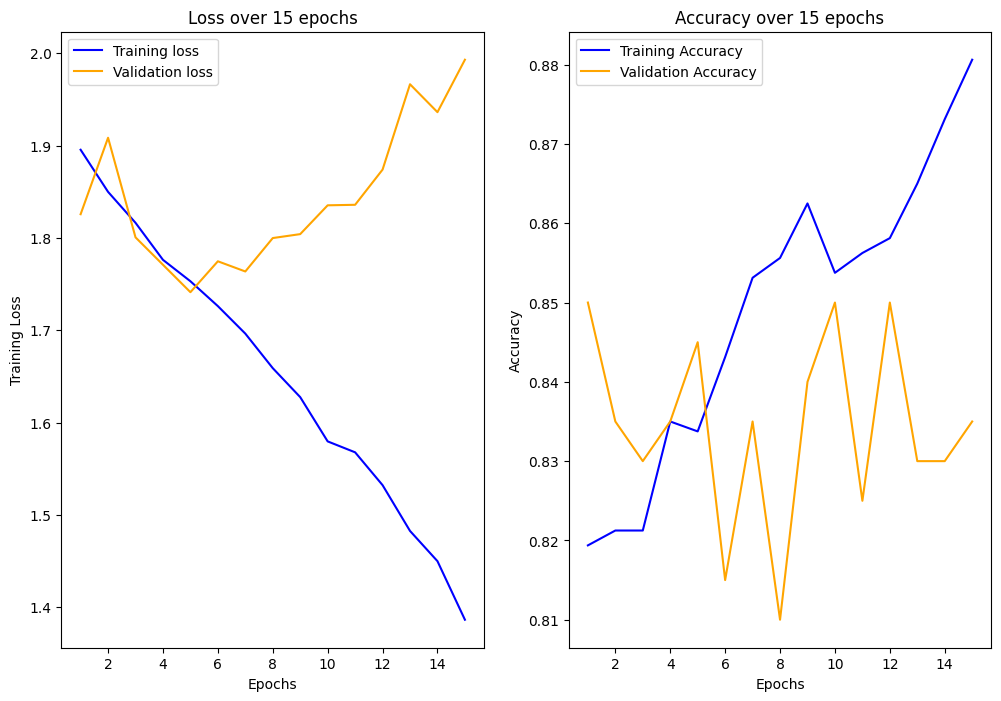

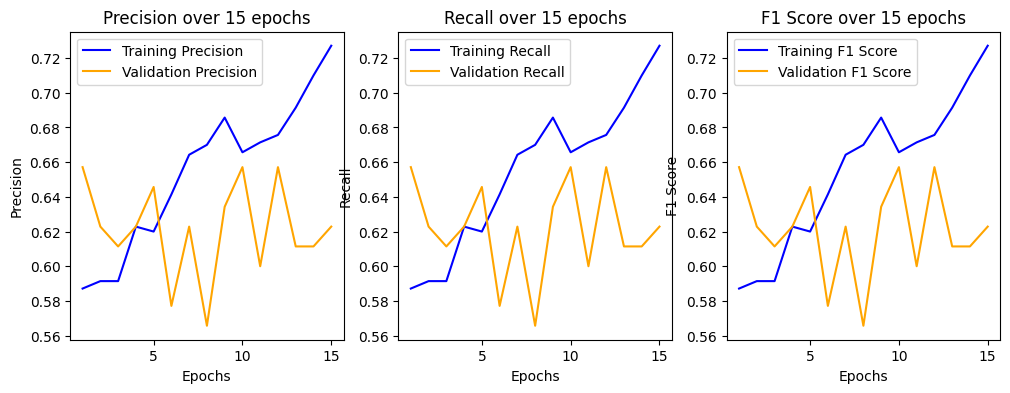

In [ ]:
plotTrainingResults(15, model2DTrainMetrics, model2DValMetrics)